In [1]:
import sys
import os
from icecream import ic

from pathlib import Path

import utils_behavior

#from utils_behavior import Ballpushing_utils
#from utils_behavior import Utils
from utils_behavior import Processing
from utils_behavior import HoloviewsTemplates

import pandas as pd
import hvplot.pandas
import numpy as np

from scipy import stats
from statsmodels.stats.multitest import multipletests
from scipy.signal import find_peaks

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pyarrow.feather as feather

import pandas as pd
import numpy as np
import holoviews as hv
import hvplot.pandas
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt
import seaborn as sns


import importlib

import holoviews as hv

#import pwlf

hv.extension("bokeh")

# Generating the dataset

In [ ]:
# Get the path to the data

Datapath = Utils.get_data_path()

In [3]:
OutputDir = Path("/mnt/upramdya_data/MD/BallPushing_Learning/Datasets/250318_Datasets")

In [ ]:
# Load already existing dataset: 

#Subset = feather.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Learning/240809_BallposData.feather")

In [ ]:
# Find folders with "Learning or learning" in the name as a list

folders = [f for f in Datapath.glob("*Learning*")]

folders

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
TestFly_path = "/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/240723_Learning_Videos_Tracked/arena5/corridor3"

TestFly = Ballpushing_utils.Fly(TestFly_path, experiment_type="Learning", as_individual=True)

TestFly.tracking_data.valid_data

In [ ]:
TestData = Ballpushing_utils.Dataset(TestFly)

In [ ]:
TestData.data.columns

In [ ]:
TestTrial2 = TestData.data[TestData.data["trial"] == 2]

TestTrial2

In [ ]:
TestTrial2["trial_time"]

In [ ]:
#Testing new module

Exps = [Ballpushing_utils.Experiment(f, experiment_type="Learning") for f in folders]

In [ ]:
Annotated_data = Ballpushing_utils.Dataset(Exps)

In [ ]:
Annotated_data.data.columns

In [ ]:
# Save the dataset in case of crash

Annotated_data.data.to_feather(OutputDir / "250320_Annotated_data.feather")

In [4]:
# Load the dataset

AnnotatedData = feather.read_feather(OutputDir / "250320_Annotated_data.feather")

In [8]:
# Check how many flies total

AnnotatedData["fly"].nunique()

161

In [12]:
# Rank the flies by maximum trial number and print the 10 flies with the most trials
Ranked_flies = AnnotatedData.groupby("fly")["trial"].max().reset_index()
Ranked_flies = Ranked_flies.sort_values("trial", ascending=False)
Ranked_flies = Ranked_flies.reset_index(drop=True)
Ranked_flies.head(10)


,fly,trial
0,240723_Learning_Videos_Tracked_arena8_corridor5,16.0
1,240723_Learning_Videos_Tracked_arena7_corridor3,14.0
2,240726_Learning_Videos_Tracked_arena1_corridor1,13.0
3,240723_Learning_Videos_Tracked_arena1_corridor2,12.0
4,240717_Learning_Videos_Tracked_arena4_corridor3,12.0
5,240726_Learning_Videos_Tracked_arena2_corridor2,11.0
6,240717_Learning_Videos_Tracked_arena9_corridor6,11.0
7,240723_Learning_Videos_Tracked_arena2_corridor1,11.0
8,240717_Learning_Videos_Tracked_arena9_corridor4,10.0
9,240717_Learning_Videos_Tracked_arena4_corridor2,9.0


In [9]:
3*54

162

In [ ]:
#Generate the experiments

Exps = [Ballpushing_utils.Experiment(f) for f in folders]

In [ ]:
Data = Ballpushing_utils.Dataset(Exps)

In [ ]:
# Save the dataset to a feather file

Data.data.to_feather(OutputDir / "250318_BallposData.feather")

# Plotting ball positions over time

In [ ]:
plot_dir = Path("/mnt/upramdya_data/MD/BallPushing_Learning/Plots/Durations")

In [ ]:
sns.lineplot(data=Annotated_data.data, x="trial_time", y="distance_ball_0", hue="trial")

In [ ]:
Subset = Annotated_data.data[Annotated_data.data["trial"] <= 5]

In [ ]:
sns.lineplot(data=Subset, x="trial_time", y="distance_ball_0", hue="trial")

# Detecting subsequent trials

In [ ]:
# Get the data columns
  
Data.data.columns

# Working with a subset

In [ ]:
# Make a subset of the data keeping only yball, yball_smooth,

Subset = Data.data[["frame","time", "y_ball_0", "distance_ball_0", "fly", "Peak", "Date"]]

# Save this subset to a feather file

#feather.write_feather(Subset, "/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Learning/240809_BallposData.feather")

In [ ]:
Subset

In [ ]:
# Get the name of the first fly and store it to use it for the next steps

fly = Subset["fly"].iloc[0]

#TestData = Subset[Subset["fly"] == fly]

# Now take one fly and plot the yball_relative

#Subset[Subset["fly"] == fly].hvplot(x="time", y="yball_relative", kind="scatter")

In [ ]:
# Compute the derivative of the yball_relative

Subset["yball_relative_derivative"] = Subset["distance_ball_0"].diff()

In [ ]:
# Do Negative peak detection on the derivative

Peaks = find_peaks(-Subset["yball_relative_derivative"], height=0.23, distance=500)

#Peaks

In [ ]:
# Extract the "time" and "Frame" columns from the dataset
frame_to_time_mapping = dict(zip(Subset["frame"], Subset["time"]))

# Convert Peaks data to lists
x_peaks = Peaks[0].tolist()
y_peaks = Peaks[1]["peak_heights"].tolist()

# Map frame indices to time values
x_peaks_time = [frame_to_time_mapping[frame] for frame in x_peaks]

# Plot the derivative and the peaks
scatter_plot = Subset.hvplot(x="time", y="yball_relative_derivative", kind="scatter")
peaks_plot = hv.Scatter(
    (x_peaks_time, y_peaks), kdims=["time"], vdims=["peak_heights"], label="Peaks"
)

# Combine the plots
combined_plot = scatter_plot * peaks_plot
#combined_plot

In [ ]:
import pandas as pd
from scipy.signal import find_peaks

# Group by individual flies
grouped = Subset.groupby("fly")


# Function to process each group
def process_group(group):
    # Find peaks in the derivative
    peaks, _ = find_peaks(
        -group["yball_relative_derivative"], height=0.3, distance=500
    )

    # Debug: Print the peaks detected for each fly
    print(f"Fly: {group['fly'].iloc[0]}, Peaks: {peaks}")

    # Initialize the "Trial" column
    group["Trial"] = 0

    # Assign trial numbers based on peak positions
    trial_number = 1
    previous_peak = 0
    for peak in peaks:
        group.iloc[previous_peak : peak + 1, group.columns.get_loc("Trial")] = (
            trial_number
        )
        trial_number += 1
        previous_peak = peak + 1

    # Assign the last trial number to the remaining rows
    group.iloc[previous_peak:, group.columns.get_loc("Trial")] = trial_number

    # Debug: Print the trial numbers assigned for each fly
    print(group[["fly", "frame", "Trial"]].head(10))

    return group


# Apply the function to each group and combine the results
Trials = grouped.apply(process_group).reset_index(drop=True)

In [ ]:
# Find how many unique trials there are grouped by fly
Trials.groupby("fly")["Trial"].nunique()

In [ ]:
# Now we can drop any fly that has less than 2 trials

Filtered = Trials.groupby("fly").filter(lambda x: x["Trial"].nunique() > 1)

Filtered

In [ ]:
Filtered.groupby("fly")["Trial"].nunique()

In [ ]:
# Group by Trial and time, then compute the mean of yball_relative
averaged_data = (
    Filtered.groupby(["Trial", "time"])["distance_ball_0"].mean().reset_index()
)

# Plot the averaged yball_relative values
# averaged_data.hvplot(
#     x="time", y="yball_relative", by="Trial", kind="line", legend="top_left"
# )

In [ ]:
# Among the flies that have more than 1 trial, we need to drop the Frames that belong to a plateau, meaning the frames where the yball_relative is above a certain threshold


# Function to clean each trial
def clean_trial(group):
    # Drop the first 500 frames
    group = group.iloc[500:]

    # Find the index where yball_relative reaches its max value for the first time
    max_index = group["distance_ball_0"].idxmax()

    # Trim the trial data to end at this maximum value
    group = group.loc[:max_index]

    return group


# Apply the function to each group and combine the results
cleaned_data = (
    Filtered.groupby(["fly", "Trial"]).apply(clean_trial).reset_index(drop=True)
)

# Display the cleaned dataset
#cleaned_data

In [ ]:
# Get the count of unique values for each trial

trial_counts = cleaned_data.groupby("Trial")["fly"].nunique()

trial_counts

In [ ]:
# Keep only trials that have atleast 30 flies

cleaned_data = cleaned_data[
    cleaned_data["Trial"].isin(trial_counts[trial_counts >= 30].index)
]

In [ ]:
# Function to compute trial duration
def compute_trial_duration(group):
    duration = group["time"].max() - group["time"].min()
    return pd.Series({"duration": duration})


# Apply the function to each group and compute the trial durations
trial_durations = (
    cleaned_data.groupby(["fly", "Trial"]).apply(compute_trial_duration).reset_index()
)

In [ ]:
# Function to compute trial duration
def compute_trial_duration(group):
    duration = group["time"].max() - group["time"].min()
    return pd.Series({"duration": duration})


# Apply the function to each group and compute the trial durations
trial_durations = (
    AnnotatedData.groupby(["fly", "trial"]).apply(compute_trial_duration).reset_index()
)

In [ ]:
# Make a function to compute trial duration as max value of trial_time grouped by trial


def compute_trial_duration(group):
    duration = group["trial_time"].max() - group["trial_time"].min()
    return pd.Series({"duration": duration})


# Compute trial duration for each trial

trial_durations = (
    AnnotatedData.groupby(["fly", "trial"]).apply(compute_trial_duration).reset_index()
)

In [ ]:
# Subset the data to keep only trials 1 to 4

Subset = trial_durations[trial_durations["trial"] <= 3]

In [ ]:
Subset

In [ ]:
sns.boxplot(
    data=Subset,
    x="trial",
    y="duration",
    color="black",
    showcaps=False,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    whiskerprops={"color": "black"},
)
sns.stripplot(data=Subset, x="trial", y="duration", hue="trial", size=4, alpha=0.5, palette = "viridis")

# Add lines connecting trials for each fly
for fly in Subset["fly"].unique():
    fly_data = Subset[Subset["fly"] == fly]
    plt.plot(
        fly_data["trial"].values - 1,
        fly_data["duration"].values,
        color="gray",
        alpha=0.2,
        linewidth=0.5,
    )
    
# Remove the legend
plt.legend().remove()
plt.xlabel("Trial")
plt.ylabel("Trial duration (s)")

plt.savefig(
    "/mnt/upramdya_data/MD/BallPushing_Learning/Plots/Durations/Trial_duration_1_4.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()
plt.close()

In [ ]:

# Calculate mean duration and confidence intervals
mean_durations = trial_durations.groupby('trial')['duration'].mean()
conf_intervals = trial_durations.groupby('trial')['duration'].apply(lambda x: Processing.draw_bs_ci(x.values))

# Plot mean duration with confidence intervals
trials = mean_durations.index
mean_values = mean_durations.values
lower_bounds = conf_intervals.apply(lambda x: x[0]).values
upper_bounds = conf_intervals.apply(lambda x: x[1]).values

plt.plot(trials, mean_values, color='blue', label='Mean Duration', marker='o')
plt.fill_between(trials, lower_bounds, upper_bounds, color='blue', alpha=0.2, label='95% CI')

plt.legend()
plt.show()

# Looking only at flies that manage atleast 4 trials

This is to check whether these flies do improve or not (as opposed to : these would be super flies that were always good compared to the others that just can't go above 2 or 3 trials)

In [ ]:
AnnotatedData.head()

In [ ]:
AnnotatedData.columns

In [5]:
#Data_Filtered = AnnotatedData[AnnotatedData["trial"] <= 4]
Data_Filtered = AnnotatedData[AnnotatedData["trial"] <= 4]

In [6]:
Data_4trials_Filtered = Data_Filtered.groupby("fly").filter(
    lambda x: x["trial"].nunique() >= 4
)

In [7]:
# Check how many flies have 4 trials
Data_4trials_Filtered.groupby("fly")["trial"].nunique().value_counts()

trial
4    64
Name: count, dtype: int64

In [45]:
# Make a function to compute trial duration as max value of trial_time grouped by trial

def compute_trial_duration(group):
    duration = group["trial_time"].max() - group["trial_time"].min()
    return pd.Series({"duration": duration})

# Compute trial duration for each trial

trial_durations = (
    Data_4trials_Filtered.groupby(["fly", "trial"])
    .apply(compute_trial_duration)
    .reset_index()
)

/tmp/ipykernel_740487/3326516094.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_trial_duration)


In [39]:
import scipy.stats as stats
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Prepare data in wide format: rows = flies, columns = trials
pivot = trial_durations.pivot(index="fly", columns="trial", values="duration").dropna()

# Friedman test
friedman_stat, friedman_p = stats.friedmanchisquare(*[pivot[col] for col in pivot.columns])
print(f"Friedman test statistic: {friedman_stat:.3f}, p-value: {friedman_p:.3g}")

# Post-hoc: Wilcoxon signed-rank test for each pair of trials
from itertools import combinations

results = []
for t1, t2 in combinations(pivot.columns, 2):
    stat, p = stats.wilcoxon(pivot[t1], pivot[t2])
    results.append({"trial1": t1, "trial2": t2, "p": p})

# Multiple testing correction
pvals = [r["p"] for r in results]
reject, pvals_corr, _, _ = multipletests(pvals, method="fdr_bh")
for i, r in enumerate(results):
    r["p_corr"] = pvals_corr[i]
    r["significant"] = reject[i]

# Print post-hoc results
print("Post-hoc Wilcoxon signed-rank tests (FDR corrected):")
for r in results:
    print(f"Trial {r['trial1']} vs {r['trial2']}: p={r['p_corr']:.4g} {'*' if r['significant'] else ''}")

Friedman test statistic: 22.969, p-value: 4.1e-05
Post-hoc Wilcoxon signed-rank tests (FDR corrected):
Trial 1.0 vs 2.0: p=0.001693 *
Trial 1.0 vs 3.0: p=0.001693 *
Trial 1.0 vs 4.0: p=0.001693 *
Trial 2.0 vs 3.0: p=0.7392 
Trial 2.0 vs 4.0: p=0.9947 
Trial 3.0 vs 4.0: p=0.3392 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


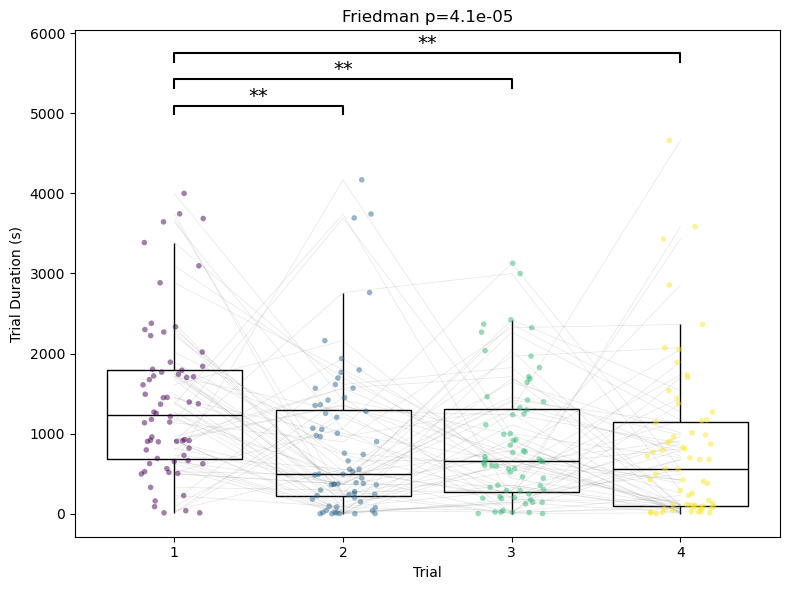

Friedman test: statistic=22.969, p=4.1e-05
Post-hoc Wilcoxon signed-rank tests (FDR corrected):
Trial 1 vs 2: p=0.001693 *
Trial 1 vs 3: p=0.001693 *
Trial 1 vs 4: p=0.001693 *
Trial 2 vs 3: p=0.7392 
Trial 2 vs 4: p=0.9947 
Trial 3 vs 4: p=0.3392 


In [40]:
# Convert trial ids to integer values
trial_durations["trial"] = trial_durations["trial"].astype(int)

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=trial_durations, x="trial", y="duration",
    color="black", showcaps=False,
    boxprops={"facecolor": "none", "edgecolor": "black"},
    whiskerprops={"color": "black"}, fliersize=0,
)
sns.stripplot(
    data=trial_durations, x="trial", y="duration",
    hue="trial", size=4, alpha=0.5, palette="viridis", jitter=0.2,
)

# Add lines connecting trials for each fly
for fly in trial_durations["fly"].unique():
    fly_data = trial_durations[trial_durations["fly"] == fly]
    plt.plot(
        fly_data["trial"].values - 1, fly_data["duration"].values,
        color="gray", alpha=0.2, linewidth=0.5
    )

plt.xlabel("Trial")
plt.ylabel("Trial Duration (s)")
plt.legend().remove()

# --- Friedman test and post-hoc Wilcoxon signed-rank tests ---
# Prepare data in wide format: rows = flies, columns = trials
pivot = trial_durations.pivot(index="fly", columns="trial", values="duration").dropna()
# Friedman test
friedman_stat, friedman_p = stats.friedmanchisquare(*[pivot[col] for col in pivot.columns])
plt.title(f"Friedman p={friedman_p:.3g}")

# Post-hoc Wilcoxon signed-rank tests
from itertools import combinations
results = []
for t1, t2 in combinations(pivot.columns, 2):
    stat, p = stats.wilcoxon(pivot[t1], pivot[t2])
    results.append({"trial1": t1, "trial2": t2, "p": p})
pvals = [r["p"] for r in results]
reject, pvals_corr, _, _ = multipletests(pvals, method="fdr_bh")
for i, r in enumerate(results):
    r["p_corr"] = pvals_corr[i]
    r["significant"] = reject[i]

# Annotate significant pairs on the plot
y_max = trial_durations["duration"].max()
y_step = (trial_durations["duration"].max() - trial_durations["duration"].min()) * 0.07
annot_y = y_max + y_step
for r in results:
    if r["significant"]:
        x1, x2 = int(r["trial1"]) - 1, int(r["trial2"]) - 1
        plt.plot([x1, x1, x2, x2], [annot_y, annot_y + y_step/3, annot_y + y_step/3, annot_y], color="k", lw=1.5)
        # Significance stars
        if r["p_corr"] < 0.001:
            stars = "***"
        elif r["p_corr"] < 0.01:
            stars = "**"
        elif r["p_corr"] < 0.05:
            stars = "*"
        else:
            stars = ""
        plt.text((x1 + x2) / 2, annot_y + y_step/3, stars, ha="center", va="bottom", color="k", fontsize=14)
        annot_y += y_step

plt.tight_layout()

plt.savefig("/mnt/upramdya_data/MD/BallPushing_Learning/Plots/Durations/Trial_Duration_4trials_withstats_jitter.eps",
    dpi=300, bbox_inches="tight", format="eps"
)
plt.savefig(
    "/mnt/upramdya_data/MD/BallPushing_Learning/Plots/Durations/Trial_Duration_4trials_withstats_jitter.png",
    dpi=300, bbox_inches="tight"
)
plt.show()

# Print test results
print(f"Friedman test: statistic={friedman_stat:.3f}, p={friedman_p:.3g}")
print("Post-hoc Wilcoxon signed-rank tests (FDR corrected):")
for r in results:
    print(f"Trial {r['trial1']} vs {r['trial2']}: p={r['p_corr']:.4g} {'*' if r['significant'] else ''}")

In [ ]:
# Get the sample size for each trial

sample_sizes = trial_durations.groupby("trial")["fly"].nunique()

sample_sizes

# Computing delta improvement fly by fly

In [ ]:
# First, make sure data is sorted by fly and trial
trial_durations = trial_durations.sort_values(['fly', 'trial'])

# Create a new dataframe to store improvement data
improvement_df = pd.DataFrame()

# Calculate improvement for each fly
for fly, group in trial_durations.groupby('fly'):
    # Make a copy of the group to avoid SettingWithCopyWarning
    fly_data = group.copy()

    # Sort by trial number
    fly_data = fly_data.sort_values("trial")

    # Calculate the difference in duration between consecutive trials
    # Negative values mean the fly got faster (improved)
    fly_data['improvement'] = fly_data['duration'].diff()

    # Create a column for the trial transition (e.g., "1 to 2")
    fly_data["Trial_transition"] = fly_data["trial"].apply(lambda x: f"{x-1} to {x}")

    # Add to our result dataframe
    improvement_df = pd.concat([improvement_df, fly_data], ignore_index=True)

# Drop the rows with NaN improvement (first trial for each fly)
improvement_df = improvement_df.dropna(subset=['improvement'])

# For easier interpretation, create a column where positive values mean improvement
improvement_df['improvement_intuitive'] = -improvement_df['improvement']

# Visualize the improvement
plt.figure(figsize=(10, 6))
sns.boxplot(data=improvement_df, x='Trial_transition', y='improvement_intuitive')
sns.stripplot(data=improvement_df, x='Trial_transition', y='improvement_intuitive', 
              color='black', size=2, alpha=0.5)

# Add lines connecting trials for each fly
for fly, group in improvement_df.groupby('fly'):
    plt.plot(group['Trial_transition'], group['improvement_intuitive'], color='gray', alpha=0.5)

plt.title('Improvement in Trial Duration')
plt.ylabel('Improvement (seconds) - Positive is better')
plt.xlabel('Trial Transition')
plt.axhline(y=0, color='r', linestyle='--')  # Add a reference line at y=0
plt.tight_layout()
plt.show()

In [ ]:
# Make a Trial column that's the same as trial
improvement_df["Trial"] = improvement_df["trial"]

trial_durations["Trial"] = trial_durations["trial"]

In [ ]:
# Make sure data is sorted by fly and trial
trial_durations = trial_durations.sort_values(['fly', 'Trial'])

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create boxplot for overall distribution
sns.boxplot(data=trial_durations, x='Trial', y='duration', color='lightgray')

# Add individual points
sns.stripplot(data=trial_durations, x='Trial', y='duration', 
              color='black', size=4, alpha=0.5, jitter=True)

# Add lines connecting trials for each fly
for fly_name, fly_data in trial_durations.groupby('fly'):
    # Sort by trial to ensure correct line connections
    fly_data = fly_data.sort_values('Trial')
    
    # Plot the line for this specific fly
    plt.plot(fly_data['Trial']-1, fly_data['duration'], 'o-', 
             linewidth=1, alpha=0.7, markersize=0,
             label=f"Fly {fly_name}")

# Add labels and title
plt.title('Trial Duration with Individual Fly Tracking', fontsize=14)
plt.ylabel('Duration (seconds)', fontsize=12)
plt.xlabel('Trial Number', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# If there are many flies, you might want to exclude the legend
# Uncomment the line below to include the legend
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Calculate improvement for each fly
improvement_df = pd.DataFrame()

for fly, group in Subset.groupby('fly'):
    # Make a copy and sort by trial
    fly_data = group.copy().sort_values("trial")

    # Calculate improvement (difference in duration)
    fly_data['improvement'] = fly_data['duration'].diff()

    # Create trial transition labels
    fly_data["Trial_transition"] = fly_data["trial"].apply(lambda x: f"{x-1} to {x}")

    # Add to our results
    improvement_df = pd.concat([improvement_df, fly_data], ignore_index=True)

# Drop the first trial for each fly (no improvement data available)
improvement_df = improvement_df.dropna(subset=['improvement'])

# For intuitive interpretation: negative becomes positive (faster is better)
improvement_df['improvement_intuitive'] = -improvement_df['improvement']

# Calculate mean improvement and bootstrapped confidence intervals
mean_improvement = improvement_df.groupby('Trial_transition')['improvement_intuitive'].mean()
conf_intervals = improvement_df.groupby('Trial_transition')['improvement_intuitive'].apply(lambda x: Processing.draw_bs_ci(x.values))

# Plot the data
plt.figure(figsize=(10, 6))

# Plot mean improvement with confidence intervals
trial_transitions = mean_improvement.index
mean_values = mean_improvement.values
lower_bounds = conf_intervals.apply(lambda x: x[0]).values
upper_bounds = conf_intervals.apply(lambda x: x[1]).values

plt.plot(trial_transitions, mean_values, color='blue', label='Mean Improvement', marker='o')
plt.fill_between(trial_transitions, lower_bounds, upper_bounds, color='blue', alpha=0.2, label='95% CI')

plt.title('Average Improvement in Trial Duration with 95% Confidence Intervals', fontsize=14)
plt.ylabel('Improvement (seconds) - Positive is better', fontsize=12)
plt.xlabel('Trial Transition', fontsize=12)
plt.axhline(y=0, color='r', linestyle='--')  # Reference line
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Calculate standard deviation and coefficient of variation per trial
variability = Subset.groupby('trial')['duration'].agg(['mean', 'std'])
variability['CV'] = variability['std'] / variability['mean']

# Print the variability DataFrame to inspect the values
print(variability)

# Plot variability metrics in separate subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot standard deviation
ax[0].plot(variability.index, variability['std'], label='Standard Deviation', marker='o')
ax[0].set_title('Standard Deviation of Trial Durations Across Trials')
ax[0].set_xlabel('Trial Number')
ax[0].set_ylabel('Standard Deviation')
ax[0].legend()
ax[0].grid()

# Plot coefficient of variation
ax[1].plot(variability.index, variability['CV'], label='Coefficient of Variation', marker='o')
ax[1].set_title('Coefficient of Variation of Trial Durations Across Trials')
ax[1].set_xlabel('Trial Number')
ax[1].set_ylabel('Coefficient of Variation')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate standard deviation and coefficient of variation per trial
variability = Subset.groupby('trial')['duration'].agg(['mean', 'std'])
variability['CV'] = variability['std'] / variability['mean']

# Print the variability DataFrame to inspect the values
print(variability)

# Calculate bootstrapped confidence intervals for standard deviation
std_conf_intervals = Subset.groupby("trial")["duration"].apply(
    lambda x: Processing.draw_bs_ci(x.values, func=np.std)
)

# Plot variability metrics in separate subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 18))

# Plot standard deviation with confidence intervals
trials = variability.index
std_values = variability['std'].values
std_lower_bounds = std_conf_intervals.apply(lambda x: x[0]).values
std_upper_bounds = std_conf_intervals.apply(lambda x: x[1]).values

ax[0].plot(trials, std_values, label='Standard Deviation', marker='o')
ax[0].fill_between(trials, std_lower_bounds, std_upper_bounds, color='blue', alpha=0.2, label='95% CI')
ax[0].set_title('Standard Deviation of Trial Durations Across Trials')
ax[0].set_xlabel('Trial Number')
ax[0].set_ylabel('Standard Deviation')
ax[0].legend()
ax[0].grid()

# Plot coefficient of variation
ax[1].plot(variability.index, variability['CV'], label='Coefficient of Variation', marker='o')
ax[1].set_title('Coefficient of Variation of Trial Durations Across Trials')
ax[1].set_xlabel('Trial Number')
ax[1].set_ylabel('Coefficient of Variation')
ax[1].legend()
ax[1].grid()

# Plot mean duration with confidence intervals
mean_durations = Subset.groupby("trial")["duration"].mean()
mean_conf_intervals = Subset.groupby("trial")["duration"].apply(
    lambda x: Processing.draw_bs_ci(x.values)
)

mean_values = mean_durations.values
mean_lower_bounds = mean_conf_intervals.apply(lambda x: x[0]).values
mean_upper_bounds = mean_conf_intervals.apply(lambda x: x[1]).values

ax[2].plot(trials, mean_values, color='blue', label='Mean Duration', marker='o')
ax[2].fill_between(trials, mean_lower_bounds, mean_upper_bounds, color='blue', alpha=0.2, label='95% CI')
ax[2].set_title('Mean Duration with 95% Confidence Intervals')
ax[2].set_xlabel('Trial Number')
ax[2].set_ylabel('Mean Duration')
ax[2].legend()
ax[2].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate correlation between consecutive trials for each fly
correlations = []
for fly, group in trial_durations.groupby('fly'):
    group = group.sort_values('Trial')
    if len(group) > 1:  # Ensure there are at least two trials
        corr = group['duration'].autocorr()
        correlations.append({'fly': fly, 'correlation': corr})

# Convert to DataFrame for visualization
correlation_df = pd.DataFrame(correlations)

# Plot correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=correlation_df, x='fly', y='correlation', palette='viridis')
plt.title('Correlation Between Consecutive Trials for Each Fly')
plt.xlabel('Fly')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
from scipy.stats import levene

# Group data by trial and extract durations
groups = [group['duration'].values for _, group in trial_durations.groupby('Trial')]

# Perform Levene's test for equality of variances
stat, p_value = levene(*groups)
print(f"Levene's Test Statistic: {stat}, p-value: {p_value}")

In [ ]:
from sklearn.linear_model import LinearRegression

slopes = []
for fly, group in trial_durations.groupby('fly'):
    group = group.sort_values('Trial')
    if len(group) > 1:  # Ensure there are enough trials for regression
        X = group['Trial'].values.reshape(-1, 1)
        y = group['duration'].values
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]  # Extract slope (rate of change)
        slopes.append({'fly': fly, 'slope': slope})

# Convert to DataFrame for visualization
slopes_df = pd.DataFrame(slopes)

# Plot slopes of improvement
plt.figure(figsize=(10, 6))
sns.barplot(data=slopes_df, x='fly', y='slope', palette='coolwarm')
plt.title('Rate of Improvement Across Flies')
plt.xlabel('Fly')
plt.ylabel('Slope of Duration Change (seconds per trial)')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
# Plot individual trajectories and mean trend line
plt.figure(figsize=(12, 8))

for fly_name, fly_data in trial_durations.groupby('fly'):
    plt.plot(fly_data['Trial'], fly_data['duration'], 'o-', alpha=0.6, label=f"Fly {fly_name}")

mean_trend = trial_durations.groupby('Trial')['duration'].mean()
plt.plot(mean_trend.index, mean_trend.values, 'k--', label='Mean Trend', linewidth=2)

plt.title('Harmonization of Trial Durations Across Flies')
plt.xlabel('Trial Number')
plt.ylabel('Duration (seconds)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

# 4 trials subset

In [ ]:
# First, make sure data is sorted by fly and trial
trial_durations = trial_durations.sort_values(['fly', 'trial'])

# Create a new dataframe to store improvement data
improvement_df = pd.DataFrame()

# Calculate improvement for each fly
for fly, group in trial_durations.groupby('fly'):
    # Make a copy of the group to avoid SettingWithCopyWarning
    fly_data = group.copy()
    
    # Sort by trial number
    fly_data = fly_data.sort_values('trial')
    
    # Calculate the difference in duration between consecutive trials
    # Negative values mean the fly got faster (improved)
    fly_data['improvement'] = fly_data['duration'].diff()
    
    # Create a column for the trial transition (e.g., "1 to 2")
    fly_data['Trial_transition'] = fly_data['trial'].apply(lambda x: f"{x-1} to {x}")
    
    # Add to our result dataframe
    improvement_df = pd.concat([improvement_df, fly_data], ignore_index=True)

# Drop the rows with NaN improvement (first trial for each fly)
improvement_df = improvement_df.dropna(subset=['improvement'])

# For easier interpretation, create a column where positive values mean improvement
improvement_df['improvement_intuitive'] = -improvement_df['improvement']

# Visualize the improvement
plt.figure(figsize=(10, 6))
sns.boxplot(data=improvement_df, x='Trial_transition', y='improvement_intuitive')
sns.stripplot(data=improvement_df, x='Trial_transition', y='improvement_intuitive', 
              color='black', size=2, alpha=0.5)

# Add lines connecting trials for each fly
for fly, group in improvement_df.groupby('fly'):
    plt.plot(group['Trial_transition'], group['improvement_intuitive'], color='gray', alpha=0.5)

plt.title('Improvement in Trial Duration')
plt.ylabel('Improvement (seconds) - Positive is better')
plt.xlabel('Trial Transition')
plt.axhline(y=0, color='r', linestyle='--')  # Add a reference line at y=0
plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


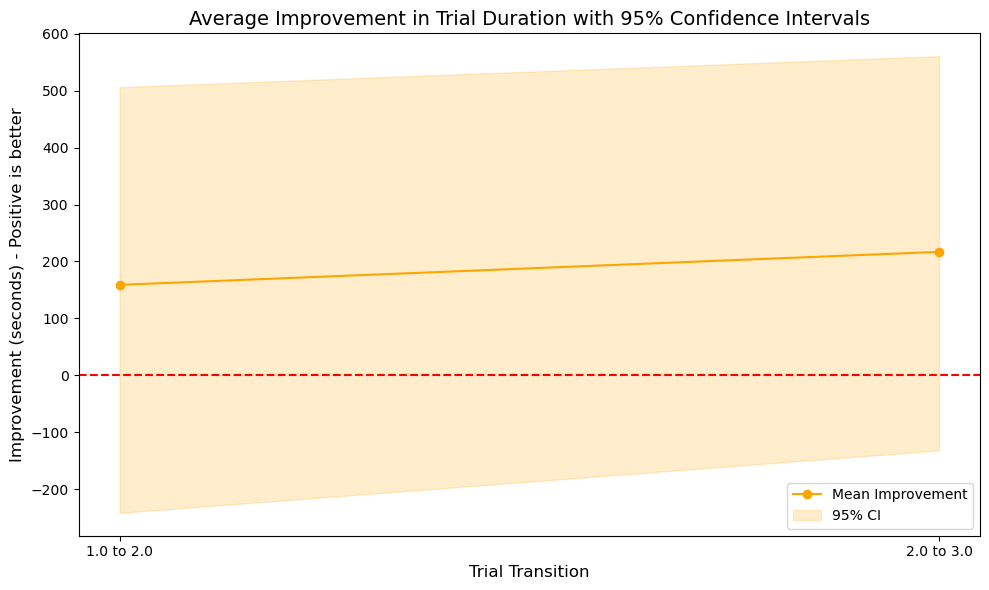

In [46]:
# Calculate improvement for each fly
improvement_df = pd.DataFrame()

for fly, group in trial_durations.groupby("fly"):
    # Make a copy and sort by trial
    fly_data = group.copy().sort_values("trial")

    # Calculate improvement (difference in duration)
    fly_data["improvement"] = fly_data["duration"].diff()

    # Create trial transition labels
    fly_data["Trial_transition"] = fly_data["trial"].apply(lambda x: f"{x-1} to {x}")

    # Add to our results
    improvement_df = pd.concat([improvement_df, fly_data], ignore_index=True)

# Drop the first trial for each fly (no improvement data available)
improvement_df = improvement_df.dropna(subset=["improvement"])

# For intuitive interpretation: negative becomes positive (faster is better)
improvement_df["improvement_intuitive"] = -improvement_df["improvement"]

# Calculate mean improvement and bootstrapped confidence intervals
mean_improvement = improvement_df.groupby("Trial_transition")[
    "improvement_intuitive"
].mean()
conf_intervals = improvement_df.groupby("Trial_transition")[
    "improvement_intuitive"
].apply(lambda x: Processing.draw_bs_ci(x.values))

# Plot the data
plt.figure(figsize=(10, 6))

# Plot mean improvement with confidence intervals
trial_transitions = mean_improvement.index
mean_values = mean_improvement.values
lower_bounds = conf_intervals.apply(lambda x: x[0]).values
upper_bounds = conf_intervals.apply(lambda x: x[1]).values

plt.plot(
    trial_transitions, mean_values, color="orange", label="Mean Improvement", marker="o"
)
plt.fill_between(
    trial_transitions,
    lower_bounds,
    upper_bounds,
    color="orange",
    alpha=0.2,
    label="95% CI",
)

plt.title(
    "Average Improvement in Trial Duration with 95% Confidence Intervals", fontsize=14
)
plt.ylabel("Improvement (seconds) - Positive is better", fontsize=12)
plt.xlabel("Trial Transition", fontsize=12)
plt.axhline(y=0, color="r", linestyle="--")  # Reference line
plt.legend()
plt.tight_layout()

plt.savefig(
    "/mnt/upramdya_data/MD/BallPushing_Learning/Plots/Durations/Trial_Improvement_3trials_withstats.eps",
    dpi=300,
    bbox_inches="tight",
    format="eps",
)
plt.savefig(
    "/mnt/upramdya_data/MD/BallPushing_Learning/Plots/Durations/Trial_Improvement_3trials_withstats.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [ ]:
# Calculate standard deviation and coefficient of variation per trial
variability = trial_durations.groupby('trial')['duration'].agg(['mean', 'std'])
variability['CV'] = variability['std'] / variability['mean']

# Print the variability DataFrame to inspect the values
print(variability)

# Calculate bootstrapped confidence intervals for standard deviation
std_conf_intervals = trial_durations.groupby('trial')['duration'].apply(lambda x: Processing.draw_bs_ci(x.values, func=np.std))

# Plot variability metrics in separate subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 18))

# Plot standard deviation with confidence intervals
trials = variability.index
std_values = variability['std'].values
std_lower_bounds = std_conf_intervals.apply(lambda x: x[0]).values
std_upper_bounds = std_conf_intervals.apply(lambda x: x[1]).values

ax[0].plot(trials, std_values, label='Standard Deviation', marker='o', color="orange")
ax[0].fill_between(trials, std_lower_bounds, std_upper_bounds, color='orange', alpha=0.2, label='95% CI')
ax[0].set_title('Standard Deviation of Trial Durations Across Trials')
ax[0].set_xlabel('Trial Number')
ax[0].set_ylabel('Standard Deviation')
ax[0].legend()
ax[0].grid()

# Plot coefficient of variation
ax[1].plot(variability.index, variability['CV'], label='Coefficient of Variation', marker='o')
ax[1].set_title('Coefficient of Variation of Trial Durations Across Trials')
ax[1].set_xlabel('Trial Number')
ax[1].set_ylabel('Coefficient of Variation')
ax[1].legend()
ax[1].grid()

# Plot mean duration with confidence intervals
mean_durations = trial_durations.groupby('trial')['duration'].mean()
mean_conf_intervals = trial_durations.groupby('trial')['duration'].apply(lambda x: Processing.draw_bs_ci(x.values))

mean_values = mean_durations.values
mean_lower_bounds = mean_conf_intervals.apply(lambda x: x[0]).values
mean_upper_bounds = mean_conf_intervals.apply(lambda x: x[1]).values

ax[2].plot(trials, mean_values, color='orange', label='Mean Duration', marker='o')
ax[2].fill_between(trials, mean_lower_bounds, mean_upper_bounds, color='orange', alpha=0.2, label='95% CI')
ax[2].set_title('Mean Duration with 95% Confidence Intervals')
ax[2].set_xlabel('Trial Number')
ax[2].set_ylabel('Mean Duration')
ax[2].legend()
ax[2].grid()

plt.tight_layout()
plt.show()

# Cumulated trials solved

In [ ]:
# Create a function to generate cumulative trials solved over time
def generate_cumulative_trials(fly_data):
    # Sort by time
    fly_data = fly_data.sort_values('time')
    
    # Find points where trial number changes (a new trial starts)
    # Each change means the previous trial was completed
    trial_changes = fly_data.loc[fly_data['Trial'].diff().fillna(0) > 0].copy()
    
    # Create a cumulative trials dataframe
    time_points = []
    trial_counts = []
    
    # Add starting point (0 trials at beginning of experiment)
    time_points.append(fly_data['time'].min())
    trial_counts.append(0)
    
    # Add each completion point
    for _, row in trial_changes.iterrows():
        time_points.append(row['time'])
        # When we see trial N start, it means N-1 trials have been completed
        trials_completed = row['Trial'] - 1
        trial_counts.append(trials_completed)
    
    # Create dataframe with time series
    cumulative_df = pd.DataFrame({
        'time': time_points,
        'cumulative_trials': trial_counts,
        'fly': fly_data['fly'].iloc[0]
    })
    
    return cumulative_df

# Apply to each fly and combine results
cumulative_trials_data = []
for fly, fly_data in Filtered.groupby('fly'):
    cum_data = generate_cumulative_trials(fly_data)
    cumulative_trials_data.append(cum_data)

cumulative_df = pd.concat(cumulative_trials_data).reset_index(drop=True)

# Plot cumulative trials over time
plt.figure(figsize=(12, 8))

# Plot individual fly trajectories
for fly, group in cumulative_df.groupby('fly'):
    plt.plot(group['time'], group['cumulative_trials'], 'o-', 
             linewidth=2, markersize=5, alpha=0.7,
             label=f"Fly {fly}")

# Add reference line showing constant rate (optional)
# max_time = cumulative_df['time'].max()
# max_trials = cumulative_df['cumulative_trials'].max()
# plt.plot([0, max_time], [0, max_trials], 'k--', alpha=0.3, label='Constant Rate')

plt.title('Cumulative Trials Solved Over Time', fontsize=14)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Cumulative Trials Completed', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Start with the original dataset (before cleaning/cropping)
original_data = Filtered.copy()  # Using Filtered which has the Trial column but before cleaning

# Function to generate cumulative trials using the original dataset
def generate_cumulative_trials_from_original(data):
    # Group by fly
    all_cumulative_data = []
    
    for fly, fly_data in data.groupby('fly'):
        # Sort by time
        fly_data = fly_data.sort_values('time')
        
        # Create a new dataframe to track trial completions
        # A trial is completed when we transition from trial N to trial N+1
        trial_completions = []
        
        # Get unique trials for this fly in order
        unique_trials = sorted(fly_data['Trial'].unique())
        
        # Track completion time for each trial
        for i in range(len(unique_trials)-1):
            current_trial = unique_trials[i]
            next_trial = unique_trials[i+1]
            
            # Find the last frame of current trial
            last_frame_current = fly_data[fly_data['Trial'] == current_trial]['time'].max()
            
            # This is when the trial was completed
            trial_completions.append({
                'fly': fly,
                'time': last_frame_current,
                'completed_trial': current_trial
            })
        
        # Convert to DataFrame
        if trial_completions:
            completions_df = pd.DataFrame(trial_completions)
            
            # Sort by time and calculate cumulative trials
            completions_df = completions_df.sort_values('time')
            completions_df['cumulative_trials'] = range(1, len(completions_df) + 1)
            
            # Add starting point (0 trials at time 0)
            start_row = pd.DataFrame({
                'fly': [fly],
                'time': [fly_data['time'].min()],
                'completed_trial': [0],
                'cumulative_trials': [0]
            })
            
            # Combine and add to results
            fly_cumulative = pd.concat([start_row, completions_df]).reset_index(drop=True)
            all_cumulative_data.append(fly_cumulative)
    
    # Combine all flies
    if all_cumulative_data:
        return pd.concat(all_cumulative_data).reset_index(drop=True)
    else:
        return pd.DataFrame()

# Generate cumulative trials data
cumulative_df = generate_cumulative_trials_from_original(original_data)

# Plot cumulative trials over time
plt.figure(figsize=(12, 8))

# Plot individual fly trajectories
for fly, group in cumulative_df.groupby('fly'):
    plt.plot(group['time'], group['cumulative_trials'], 'o-', 
             linewidth=2, markersize=5, alpha=0.7,
             label=f"Fly {fly}")

plt.title('Cumulative Trials Solved Over Time', fontsize=14)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Cumulative Trials Completed', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Start with the original dataset that has Trial annotations
original_data = Filtered.copy()

# Function to generate cumulative trials for all flies pooled together
def generate_pooled_cumulative_trials(data):
    # Create a list to store all flies' cumulative data with normalized time
    all_fly_data = []
    
    for fly, fly_data in data.groupby('fly'):
        # Sort by time
        fly_data = fly_data.sort_values('time')
        
        # Find transitions between trials (when Trial value changes)
        fly_data['trial_change'] = fly_data['Trial'].diff().fillna(0) != 0
        transitions = fly_data[fly_data['trial_change']].copy()
        
        if len(transitions) > 0:
            # Calculate cumulative trials
            transitions['completed_trial'] = transitions['Trial'] - 1
            transitions = transitions[transitions['completed_trial'] > 0].copy()
            
            # Add starting point (0 trials at beginning)
            start_time = fly_data['time'].min()
            start_row = pd.DataFrame({
                'fly': [fly],
                'time': [start_time],
                'completed_trial': [0]
            })
            
            # Combine starting point with transitions
            fly_cumulative = pd.concat([
                start_row, 
                transitions[['fly', 'time', 'completed_trial']]
            ]).reset_index(drop=True)
            
            # Normalize time to start at 0
            fly_cumulative['time_normalized'] = fly_cumulative['time'] - start_time
            
            # Add to collection
            all_fly_data.append(fly_cumulative)
    
    # Combine all flies data
    if all_fly_data:
        return pd.concat(all_fly_data).reset_index(drop=True)
    else:
        return pd.DataFrame()

# Generate cumulative trials data
cumulative_data = generate_pooled_cumulative_trials(original_data)

# Create time bins for pooling (e.g., every 5 seconds)
bin_size = 5  # seconds
max_time = cumulative_data['time_normalized'].max()
time_bins = np.arange(0, max_time + bin_size, bin_size)

# Function to find the cumulative trials at each time bin for each fly
def get_trials_at_timepoints(fly_data, timepoints):
    results = []
    for t in timepoints:
        # Find the maximum trials completed before or at this time
        trials_at_time = fly_data[fly_data['time_normalized'] <= t]['completed_trial'].max()
        results.append({
            'fly': fly_data['fly'].iloc[0],
            'time_bin': t,
            'cumulative_trials': trials_at_time if not np.isnan(trials_at_time) else 0
        })
    return pd.DataFrame(results)

# Apply to each fly and combine
binned_data = []
for fly, group in cumulative_data.groupby('fly'):
    fly_bins = get_trials_at_timepoints(group, time_bins)
    binned_data.append(fly_bins)

binned_df = pd.concat(binned_data).reset_index(drop=True)

# Calculate mean and confidence intervals at each time bin
from scipy import stats

summary_stats = binned_df.groupby('time_bin').agg(
    mean_trials=('cumulative_trials', 'mean'),
    std_trials=('cumulative_trials', 'std'),
    n_flies=('fly', 'nunique')
).reset_index()

# Calculate 95% confidence intervals
summary_stats['ci_95'] = summary_stats.apply(
    lambda row: 1.96 * row['std_trials'] / np.sqrt(row['n_flies']) 
    if row['n_flies'] > 0 else 0, axis=1
)



In [ ]:
# Generate a linear regression model for the mean trials

# Define the linear regression model

def linear_model(x, a, b):
    return a * x + b

# Fit the linear model to the data

popt, _ = curve_fit(linear_model, summary_stats['time_bin'], summary_stats['mean_trials'])

# Calculate the R-squared value

r2 = r2_score(summary_stats['mean_trials'], linear_model(summary_stats['time_bin'], *popt))

print(f"Linear Model: y = {popt[0]:.2f} * x + {popt[1]:.2f}, R-squared: {r2:.2f}")

In [ ]:
# Generate a logistic regression model for the mean trials

# Define the logistic regression model

def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

# Fit the logistic model to the data

popt_log, _ = curve_fit(logistic_model, summary_stats['time_bin'], summary_stats['mean_trials'], maxfev=10000)

# Calculate the R-squared value

r2_log = r2_score(summary_stats['mean_trials'], logistic_model(summary_stats['time_bin'], *popt_log))

print(f"Logistic Model: y = {popt_log[2]:.2f} / (1 + exp(-(x - {popt_log[1]:.2f}) / {popt_log[0]:.2f}), R-squared: {r2:.2f}")

In [ ]:
# Generate a piecewise linear regression model for the mean trials

# Define the piecewise linear regression model

def piecewise_linear(x, a, b, c):
    # Convert to numpy array to ensure proper handling
    x = np.asarray(x)
    
    # Create output array of the same shape
    result = np.zeros_like(x)
    
    # Apply the piecewise function manually
    mask = x < c
    result[mask] = a * x[mask] + b      # First piece: ax + b when x < c
    result[~mask] = a * c + b           # Second piece: constant when x >= c
    
    return result


# Fit the piecewise linear model to the data

popt_pw, _ = curve_fit(piecewise_linear, summary_stats['time_bin'], summary_stats['mean_trials'])

# Calculate the R-squared value

r2_pw = r2_score(summary_stats['mean_trials'], piecewise_linear(summary_stats['time_bin'], *popt_pw))

print(f"Piecewise Linear Model: y = {popt_pw[0]:.2f} * x + {popt_pw[1]:.2f} (x < {popt_pw[2]:.2f}), R-squared: {r2_pw:.2f}")


In [ ]:
# Function to generate cumulative trials for all flies pooled together
def generate_pooled_cumulative_trials(data):
    # Create a list to store all flies' cumulative data with normalized time
    all_fly_data = []

    for fly, fly_data in data.groupby('fly'):
        # Sort by time
        fly_data = fly_data.sort_values('time')

        # Find transitions between trials (when Trial value changes)
        fly_data['trial_change'] = fly_data['trial'].diff().fillna(0) != 0
        transitions = fly_data[fly_data['trial_change']].copy()

        if len(transitions) > 0:
            # Calculate cumulative trials
            transitions['completed_trial'] = transitions['trial'] - 1
            transitions = transitions[transitions['completed_trial'] > 0].copy()

            # Add starting point (0 trials at beginning)
            start_time = fly_data['time'].min()
            start_row = pd.DataFrame({
                'fly': [fly],
                'time': [start_time],
                'completed_trial': [0]
            })

            # Combine starting point with transitions
            fly_cumulative = pd.concat([
                start_row, 
                transitions[['fly', 'time', 'completed_trial']]
            ]).reset_index(drop=True)

            # Normalize time to start at 0
            fly_cumulative['time_normalized'] = fly_cumulative['time'] - start_time

            # Add to collection
            all_fly_data.append(fly_cumulative)

    # Combine all flies data
    if all_fly_data:
        return pd.concat(all_fly_data).reset_index(drop=True)
    else:
        return pd.DataFrame()

# Generate cumulative trials data
cumulative_data = generate_pooled_cumulative_trials(Data_Filtered)

# Create time bins for pooling (e.g., every 5 seconds)
bin_size = 5  # seconds
max_time = cumulative_data['time_normalized'].max()
time_bins = np.arange(0, max_time + bin_size, bin_size)

# Function to find the cumulative trials at each time bin for each fly
def get_trials_at_timepoints(fly_data, timepoints):
    results = []
    for t in timepoints:
        # Find the maximum trials completed before or at this time
        trials_at_time = fly_data[fly_data['time_normalized'] <= t]['completed_trial'].max()
        results.append({
            'fly': fly_data['fly'].iloc[0],
            'time_bin': t,
            'cumulative_trials': trials_at_time if not np.isnan(trials_at_time) else 0
        })
    return pd.DataFrame(results)

# Apply to each fly and combine
binned_data = []
for fly, group in cumulative_data.groupby('fly'):
    fly_bins = get_trials_at_timepoints(group, time_bins)
    binned_data.append(fly_bins)

binned_df = pd.concat(binned_data).reset_index(drop=True)

# Calculate mean and confidence intervals at each time bin
from scipy import stats

summary_stats = binned_df.groupby('time_bin').agg(
    mean_trials=('cumulative_trials', 'mean'),
    std_trials=('cumulative_trials', 'std'),
    n_flies=('fly', 'nunique')
).reset_index()

# Calculate 95% confidence intervals
summary_stats['ci_95'] = summary_stats.apply(
    lambda row: 1.96 * row['std_trials'] / np.sqrt(row['n_flies']) 
    if row['n_flies'] > 0 else 0, axis=1
)

In [ ]:
# Plot pooled cumulative trials over time with confidence intervals
plt.figure(figsize=(12, 8))

# Plot mean line
plt.plot(summary_stats['time_bin'], summary_stats['mean_trials'], 'b-', 
         linewidth=2, label='Mean Cumulative Trials', color="blue")

# Add confidence interval
plt.fill_between(
    summary_stats["time_bin"],
    summary_stats["mean_trials"] - summary_stats["ci_95"],
    summary_stats["mean_trials"] + summary_stats["ci_95"],
    color="blue",
    alpha=0.2,
    label="95% Confidence Interval",
)

# Overlay individual fly trajectories with lower opacity
for fly, group in binned_df.groupby('fly'):
    plt.plot(group['time_bin'], group['cumulative_trials'], '-', 
             linewidth=1, alpha=0.2, color='gray')

# Add the regression line to the plot

plt.plot(summary_stats['time_bin'], linear_model(summary_stats['time_bin'], *popt), 'r--',
         linewidth=2, label=f'Linear Fit (R^2={r2:.2f})')

# Add the logistic regression line to the plot

plt.plot(summary_stats['time_bin'], logistic_model(summary_stats['time_bin'], *popt_log), 'g--',
         linewidth=2, label=f'Logistic Fit (R^2={r2_log:.2f})')

plt.title('Pooled Cumulative Trials Solved Over Time', fontsize=14)
plt.xlabel('Time Since Start (seconds)', fontsize=12)
plt.ylabel('Average Cumulative Trials Completed', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4 trials control

In [ ]:
# Function to generate cumulative trials for all flies pooled together
def generate_pooled_cumulative_trials(data):
    # Create a list to store all flies' cumulative data with normalized time
    all_fly_data = []
    
    for fly, fly_data in data.groupby('fly'):
        # Sort by time
        fly_data = fly_data.sort_values('time')
        
        # Find transitions between trials (when Trial value changes)
        fly_data['trial_change'] = fly_data['trial'].diff().fillna(0) != 0
        transitions = fly_data[fly_data['trial_change']].copy()
        
        if len(transitions) > 0:
            # Calculate cumulative trials
            transitions['completed_trial'] = transitions['trial'] - 1
            transitions = transitions[transitions['completed_trial'] > 0].copy()
            
            # Add starting point (0 trials at beginning)
            start_time = fly_data['time'].min()
            start_row = pd.DataFrame({
                'fly': [fly],
                'time': [start_time],
                'completed_trial': [0]
            })
            
            # Combine starting point with transitions
            fly_cumulative = pd.concat([
                start_row, 
                transitions[['fly', 'time', 'completed_trial']]
            ]).reset_index(drop=True)
            
            # Normalize time to start at 0
            fly_cumulative['time_normalized'] = fly_cumulative['time'] - start_time
            
            # Add to collection
            all_fly_data.append(fly_cumulative)
    
    # Combine all flies data
    if all_fly_data:
        return pd.concat(all_fly_data).reset_index(drop=True)
    else:
        return pd.DataFrame()

# Generate cumulative trials data
cumulative_data = generate_pooled_cumulative_trials(Data_4trials_Filtered)

# Create time bins for pooling (e.g., every 5 seconds)
bin_size = 5  # seconds
max_time = cumulative_data['time_normalized'].max()
time_bins = np.arange(0, max_time + bin_size, bin_size)

# Function to find the cumulative trials at each time bin for each fly
def get_trials_at_timepoints(fly_data, timepoints):
    results = []
    for t in timepoints:
        # Find the maximum trials completed before or at this time
        trials_at_time = fly_data[fly_data['time_normalized'] <= t]['completed_trial'].max()
        results.append({
            'fly': fly_data['fly'].iloc[0],
            'time_bin': t,
            'cumulative_trials': trials_at_time if not np.isnan(trials_at_time) else 0
        })
    return pd.DataFrame(results)

# Apply to each fly and combine
binned_data = []
for fly, group in cumulative_data.groupby('fly'):
    fly_bins = get_trials_at_timepoints(group, time_bins)
    binned_data.append(fly_bins)

binned_df = pd.concat(binned_data).reset_index(drop=True)

# Calculate mean and confidence intervals at each time bin
from scipy import stats

summary_stats = binned_df.groupby('time_bin').agg(
    mean_trials=('cumulative_trials', 'mean'),
    std_trials=('cumulative_trials', 'std'),
    n_flies=('fly', 'nunique')
).reset_index()

# Calculate 95% confidence intervals
summary_stats['ci_95'] = summary_stats.apply(
    lambda row: 1.96 * row['std_trials'] / np.sqrt(row['n_flies']) 
    if row['n_flies'] > 0 else 0, axis=1
)


In [ ]:
# Plot pooled cumulative trials over time with confidence intervals
plt.figure(figsize=(12, 8))

# Plot mean line
plt.plot(summary_stats['time_bin'], summary_stats['mean_trials'], 'b-', 
         linewidth=2, label='Mean Cumulative Trials', color="orange")

# Add confidence interval
plt.fill_between(
    summary_stats['time_bin'],
    summary_stats['mean_trials'] - summary_stats['ci_95'],
    summary_stats['mean_trials'] + summary_stats['ci_95'],
    color='orange', alpha=0.2, label='95% Confidence Interval'
)

# Overlay individual fly trajectories with lower opacity
for fly, group in binned_df.groupby('fly'):
    plt.plot(group['time_bin'], group['cumulative_trials'], '-', 
             linewidth=1, alpha=0.2, color='gray')

# Add the regression line to the plot

plt.plot(summary_stats['time_bin'], linear_model(summary_stats['time_bin'], *popt), 'r--',
         linewidth=2, label=f'Linear Fit (R^2={r2:.2f})')

# Add the logistic regression line to the plot

plt.plot(summary_stats['time_bin'], logistic_model(summary_stats['time_bin'], *popt_log), 'g--',
         linewidth=2, label=f'Logistic Fit (R^2={r2_log:.2f})')

plt.title('Pooled Cumulative Trials Solved Over Time', fontsize=14)
plt.xlabel('Time Since Start (seconds)', fontsize=12)
plt.ylabel('Average Cumulative Trials Completed', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

The data when only considering the first trials seems to be much more meaningful actually, as the later trials are kind of making things blurry. Let's Try both conditions with only the subset trials just to be sure

# Separating learners and non learners

In [ ]:
# Define curve functions
def linear_curve(x, a, b):
    return a * x + b  # Constant learning rate

def sigmoid_curve(x, L_max, k, t0):
    # Logistic sigmoid function with 3 parameters
    return L_max / (1 + np.exp(-k * (x - t0)))

# Process each fly
fit_results = []

for fly, group in cumulative_df.groupby('fly'):
    # Extract data points
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Ensure data is float64 to avoid numerical issues
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    
    # Fit linear curve
    linear_params, _ = curve_fit(linear_curve, x, y)
    linear_fit = linear_curve(x, *linear_params)
    linear_r2 = r2_score(y, linear_fit)
    
    # Initial guess for sigmoid params (important for convergence)
    p0 = [max(y) * 1.1, 1, np.median(x)]
    
    # Multiple attempts with different initial parameters if needed
    try:
        # First attempt with default parameters
        sigmoid_params, _ = curve_fit(sigmoid_curve, x, y, p0=p0, maxfev=10000)
        sigmoid_fit = sigmoid_curve(x, *sigmoid_params)
        sigmoid_r2 = r2_score(y, sigmoid_fit)
        
        # If R² is negative, try alternative parameter guesses
        if sigmoid_r2 < 0:
            # Alternative parameter guesses
            alt_p0 = [max(y), 0.1, np.median(x)]
            sigmoid_params, _ = curve_fit(sigmoid_curve, x, y, p0=alt_p0, maxfev=10000)
            sigmoid_fit = sigmoid_curve(x, *sigmoid_params)
            sigmoid_r2 = r2_score(y, sigmoid_fit)
            
    except:
        # For flies where sigmoid fitting fails, use linear fit R² instead
        print(f"Warning: Sigmoid fitting failed for fly {fly}. Using linear model.")
        sigmoid_params = None
        sigmoid_r2 = linear_r2  # Use linear R² instead of -Inf
    
    # Store results with proper handling for failed fits
    fit_results.append({
        'fly': fly,
        'linear_r2': linear_r2,
        'sigmoid_r2': sigmoid_r2 if sigmoid_params is not None else linear_r2,
        'r2_diff': (sigmoid_r2 - linear_r2) if sigmoid_params is not None else 0,
        'linear_params': linear_params,
        'sigmoid_params': sigmoid_params,
        'sigmoid_fit_failed': sigmoid_params is None
    })
    
    print(f"Fly {fly}: Linear R^2 = {linear_r2:.2f}, Sigmoid R^2 = {sigmoid_r2:.2f}")

# Convert to DataFrame
fit_results_df = pd.DataFrame(fit_results)

# Classify flies - learners have better sigmoid fit
r2_improvement_threshold = 0.05  # Minimum difference to classify as learner
# Only consider flies where sigmoid fitting succeeded
fit_results_df['is_learner'] = (fit_results_df['r2_diff'] > r2_improvement_threshold) & (~fit_results_df['sigmoid_fit_failed'])


In [ ]:
# Count how many flies are classified as learners vs. non-learners

learner_counts = fit_results_df['is_learner'].value_counts()
print(learner_counts)

In [ ]:
# Create visualization
plt.figure(figsize=(14, 8))

# Plot each fly with appropriate color coding
for _, row in fit_results_df.iterrows():
    fly = row['fly']
    is_learner = row['is_learner']
    
    # Get fly data
    group = cumulative_df[cumulative_df['fly'] == fly]
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Set color and label
    color = 'green' if is_learner else 'red'
    label = f"Fly{fly} ({'Learner' if is_learner else 'Non-Learner'})"
    
    # Plot data points
    plt.scatter(x, y, color=color, alpha=0.7)
    
    # Plot the best-fit curve
    x_smooth = np.linspace(min(x), max(x), 100)
    
    if is_learner and row['sigmoid_params'] is not None:
        # Plot sigmoid curve for learners
        y_smooth = sigmoid_curve(x_smooth, *row['sigmoid_params'])
        plt.plot(x_smooth, y_smooth, '--', color=color, alpha=0.8, label=label)
    else:
        # Linear fit for non-learners
        y_smooth = linear_curve(x_smooth, *row['linear_params'])
        plt.plot(x_smooth, y_smooth, '--', color=color, alpha=0.8, label=label)

plt.title('Learners vs Non-Learners Based on Curve Fitting', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Trials Solved', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Define curve functions
def linear_curve(x, a, b):
    return a * x + b  # Constant learning rate

def logistic_curve(x, L_max, k, t0):
    # Logistic sigmoid function with 3 parameters
    return L_max / (1 + np.exp(-k * (x - t0)))

# Process each fly
fit_results = []

for fly, group in cumulative_df.groupby('fly'):
    # Extract data points
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Ensure data is float64 to avoid numerical issues
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    
    # Fit linear curve
    linear_params, _ = curve_fit(linear_curve, x, y)
    linear_fit = linear_curve(x, *linear_params)
    linear_r2 = r2_score(y, linear_fit)
    
    # Initial guess for logistic params (important for convergence)
    p0 = [max(y) * 1.2, 0.5, np.median(x)]
    bounds = ([0, 0, min(x)], [max(y) * 2, 10, max(x)])
    
    # Fit logistic curve with robust error handling
    logistic_successful = False
    try:
        # Try with default parameters
        logistic_params, _ = curve_fit(logistic_curve, x, y, p0=p0, bounds=bounds, maxfev=10000)
        logistic_fit = logistic_curve(x, *logistic_params)
        logistic_r2 = r2_score(y, logistic_fit)
        
        # Check if the R² is valid
        if logistic_r2 > 0:
            logistic_successful = True
            
    except Exception as e:
        print(f"Initial logistic fit failed for fly {fly}: {e}")
    
    # Try alternative parameters if first attempt failed
    if not logistic_successful:
        try:
            # Try with alternative parameters
            alt_p0 = [max(y), 0.1, np.mean(x)]
            logistic_params, _ = curve_fit(logistic_curve, x, y, p0=alt_p0, bounds=bounds, maxfev=10000)
            logistic_fit = logistic_curve(x, *logistic_params)
            logistic_r2 = r2_score(y, logistic_fit)
            logistic_successful = True
        except Exception as e:
            print(f"Alternative logistic fit failed for fly {fly}: {e}")
            logistic_params = None
            logistic_r2 = -1  # Use -1 instead of -Inf
    
    # Calculate improvement in fit
    r2_diff = logistic_r2 - linear_r2 if logistic_successful else 0
    
    # Store results
    fit_results.append({
        'fly': fly,
        'linear_r2': linear_r2,
        'logistic_r2': logistic_r2 if logistic_successful else -1,
        'r2_diff': r2_diff,
        'linear_params': linear_params,
        'logistic_params': logistic_params,
        'logistic_successful': logistic_successful
    })
    
    print(f"Fly {fly}: Linear R² = {linear_r2:.4f}, Logistic R² = {logistic_r2:.4f}, Diff = {r2_diff:.4f}")

# Convert to DataFrame
fit_results_df = pd.DataFrame(fit_results)

# Classify flies - learners have better logistic fit by a threshold
r2_improvement_threshold = 0.03  # Minimum difference to classify as learner
fit_results_df['is_learner'] = (fit_results_df['r2_diff'] > r2_improvement_threshold) & (fit_results_df['logistic_successful'])

# Summarize classification results
num_learners = fit_results_df['is_learner'].sum()
num_non_learners = len(fit_results_df) - num_learners
print(f"\nClassification results:")
print(f"Learners: {num_learners} flies")
print(f"Non-learners: {num_non_learners} flies")


In [ ]:
# Plot all fits
plt.figure(figsize=(15, 10))

# Create a color palette
learner_color = 'green'
non_learner_color = 'red'

# First, plot non-learners (so learners appear on top)
for _, row in fit_results_df[~fit_results_df['is_learner']].iterrows():
    fly = row['fly']
    group = cumulative_df[cumulative_df['fly'] == fly]
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Plot data points
    plt.scatter(x, y, color=non_learner_color, alpha=0.5)
    
    # Plot linear fit (which is better for non-learners)
    x_smooth = np.linspace(min(x), max(x), 100)
    y_linear = linear_curve(x_smooth, *row['linear_params'])
    plt.plot(x_smooth, y_linear, '-', color=non_learner_color, alpha=0.3)

# Then plot learners
for _, row in fit_results_df[fit_results_df['is_learner']].iterrows():
    fly = row['fly']
    group = cumulative_df[cumulative_df['fly'] == fly]
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Plot data points
    plt.scatter(x, y, color=learner_color, alpha=0.5)
    
    # Plot logistic fit
    if row['logistic_successful']:
        x_smooth = np.linspace(min(x), max(x), 100)
        y_logistic = logistic_curve(x_smooth, *row['logistic_params'])
        plt.plot(x_smooth, y_logistic, '-', color=learner_color, alpha=0.3)

# Add representative curves for legend
x_demo = np.linspace(0, 1, 100)
plt.plot([], [], '-', color=learner_color, label='Learners (Logistic Fit)')
plt.plot([], [], '-', color=non_learner_color, label='Non-Learners (Linear Fit)')

plt.title('Classification of Flies Based on Learning Curve Shape', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Trials Solved', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show a few representative examples in detail
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Representative Examples of Learners vs Non-Learners', fontsize=16)

# Get 2 best learners and 2 best non-learners
top_learners = fit_results_df[fit_results_df['is_learner']].nlargest(2, 'r2_diff')
top_non_learners = fit_results_df[~fit_results_df['is_learner']].nsmallest(2, 'r2_diff')

# Plot each example
for i, (idx, row) in enumerate(pd.concat([top_learners, top_non_learners]).iterrows()):
    fly = row['fly']
    is_learner = row['is_learner']
    
    # Calculate subplot position
    r, c = i // 2, i % 2
    ax = axs[r, c]
    
    # Get fly data
    group = cumulative_df[cumulative_df['fly'] == fly]
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Plot data points
    ax.scatter(x, y, color='blue', s=50, label='Data Points')
    
    # Plot curves
    x_smooth = np.linspace(min(x), max(x), 100)
    
    # Always plot linear fit
    y_linear = linear_curve(x_smooth, *row['linear_params'])
    ax.plot(x_smooth, y_linear, '--', color='orange', label=f'Linear (R²={row["linear_r2"]:.4f})')
    
    # Plot logistic fit if available
    if row['logistic_successful']:
        y_logistic = logistic_curve(x_smooth, *row['logistic_params'])
        ax.plot(x_smooth, y_logistic, '-', color='green', label=f'Logistic (R²={row["logistic_r2"]:.4f})')
    
    # Add title and label
    ax.set_title(f"Fly {fly}: {'Learner' if is_learner else 'Non-Learner'}", fontsize=14)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Cumulative Trials', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [ ]:
# Define multiple curve functions
def linear_curve(x, a, b):
    return a * x + b

def logistic_curve(x, L_max, k, t0):
    return L_max / (1 + np.exp(-k * (x - t0)))

def piecewise_linear(x, x0, y0, k1, k2):
    return np.where(x < x0, y0 + k1 * (x - x0), y0 + k2 * (x - x0))

# Create empty list to store results
fit_results = []

# Process each fly
for fly, group in cumulative_df.groupby('fly'):
    # Extract data points
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Fit all three models
    models = {}
    
    # Linear fit
    try:
        linear_params, _ = curve_fit(linear_curve, x, y)
        linear_fit = linear_curve(x, *linear_params)
        linear_r2 = r2_score(y, linear_fit)
        models['linear'] = {'params': linear_params, 'r2': linear_r2, 'fit': linear_fit}
    except:
        models['linear'] = {'r2': -1, 'params': None}
    
    # Logistic fit
    try:
        p0 = [max(y) * 1.2, 0.5, np.median(x)]
        bounds = ([0, 0, min(x)], [max(y) * 2, 10, max(x)])
        logistic_params, _ = curve_fit(logistic_curve, x, y, p0=p0, bounds=bounds, maxfev=10000)
        logistic_fit = logistic_curve(x, *logistic_params)
        logistic_r2 = r2_score(y, logistic_fit)
        models['logistic'] = {'params': logistic_params, 'r2': logistic_r2, 'fit': logistic_fit}
    except:
        models['logistic'] = {'r2': -1, 'params': None}
    
    # Piecewise linear fit
    try:
        x0_guess = (min(x) + max(x)) / 2
        y0_guess = np.median(y)
        p0 = [x0_guess, y0_guess, 0.5, 1.5]
        piecewise_params, _ = curve_fit(piecewise_linear, x, y, p0=p0, maxfev=10000)
        piecewise_fit = piecewise_linear(x, *piecewise_params)
        piecewise_r2 = r2_score(y, piecewise_fit)
        models['piecewise'] = {'params': piecewise_params, 'r2': piecewise_r2, 'fit': piecewise_fit}
    except:
        models['piecewise'] = {'r2': -1, 'params': None}
    
    # Find best model
    best_model = max(models.items(), key=lambda x: x[1]['r2'])
    best_model_name = best_model[0]
    
    # Calculate r2_improvement for non-linear models
    logistic_improvement = models['logistic']['r2'] - models['linear']['r2'] 
    piecewise_improvement = models['piecewise']['r2'] - models['linear']['r2']
    
    # Get the maximum improvement
    max_improvement = max(logistic_improvement, piecewise_improvement)
    
    # Store results including the improvement metrics
    result_dict = {
        'fly': fly,
        'linear_r2': models['linear']['r2'],
        'logistic_r2': models['logistic']['r2'],
        'piecewise_r2': models['piecewise']['r2'],
        'linear_params': models['linear']['params'],
        'logistic_params': models['logistic']['params'],
        'piecewise_params': models['piecewise']['params'],
        'best_model': best_model_name,
        'fly_type': 'Non-learner' if best_model_name == 'linear' else 'Learner',
        'r2_improvement': max_improvement,
        'logistic_improvement': logistic_improvement,
        'piecewise_improvement': piecewise_improvement
    }
    
    fit_results.append(result_dict)

# Convert to DataFrame
fit_results_df = pd.DataFrame(fit_results)

In [ ]:
# Define learning criteria
r2_improvement_threshold = 0.03  # Minimum R² improvement to consider non-linear models

# Classify fly based on model comparison
if (models['logistic']['r2'] > models['linear']['r2'] + r2_improvement_threshold or
    models['piecewise']['r2'] > models['linear']['r2'] + r2_improvement_threshold):
    fly_type = 'Learner'
else:
    fly_type = 'Non-learner'


In [ ]:
# Create a 'fly_type' column based on the 'is_learner' classification
fit_results_df['fly_type'] = 'Non-learner'  # Default value
fit_results_df.loc[fit_results_df['is_learner'], 'fly_type'] = 'Learner'

# Further categorize the learners based on their best model
# Only apply this to rows where is_learner is True and best_model exists
if 'best_model' in fit_results_df.columns:
    mask = (fit_results_df['is_learner']) & (fit_results_df['best_model'] == 'piecewise')
    fit_results_df.loc[mask, 'fly_type'] = 'Piecewise Learner'
    
    mask = (fit_results_df['is_learner']) & (fit_results_df['best_model'] == 'logistic')
    fit_results_df.loc[mask, 'fly_type'] = 'Logistic Learner'


In [ ]:
# Create a main summary plot
plt.figure(figsize=(15, 10))

# Define colors for different types
learner_color = 'green'
non_learner_color = 'red'
piecewise_learner_color = 'blue'

# Plot non-learners first (so learners appear on top)
for _, row in fit_results_df[fit_results_df['fly_type'] == 'Non-learner'].iterrows():
    fly = row['fly']
    group = cumulative_df[cumulative_df['fly'] == fly]
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Plot data points
    plt.scatter(x, y, color=non_learner_color, alpha=0.5, s=20)
    
    # Plot linear fit
    x_smooth = np.linspace(min(x), max(x), 100)
    y_linear = linear_curve(x_smooth, *row['linear_params'])
    plt.plot(x_smooth, y_linear, '-', color=non_learner_color, alpha=0.3)

# Plot learners with differentiation by best model
for _, row in fit_results_df[fit_results_df['fly_type'] == 'Learner'].iterrows():
    fly = row['fly']
    group = cumulative_df[cumulative_df['fly'] == fly]
    x = group['time'].values
    y = group['cumulative_trials'].values
    
    # Set color based on best model
    model_color = piecewise_learner_color if row['best_model'] == 'piecewise' else learner_color
    
    # Plot data points
    plt.scatter(x, y, color=model_color, alpha=0.5, s=20)
    
    # Plot the best fit
    x_smooth = np.linspace(min(x), max(x), 100)
    if row['best_model'] == 'logistic':
        y_fit = logistic_curve(x_smooth, *row['logistic_params'])
        plt.plot(x_smooth, y_fit, '-', color=learner_color, alpha=0.3)
    elif row['best_model'] == 'piecewise':
        y_fit = piecewise_linear(x_smooth, *row['piecewise_params'])
        plt.plot(x_smooth, y_fit, '-', color=piecewise_learner_color, alpha=0.3)

# Add legend elements using empty plots
plt.plot([], [], 'o-', color=non_learner_color, label='Non-Learner (Linear)')
plt.plot([], [], 'o-', color=learner_color, label='Logistic Learner')
plt.plot([], [], 'o-', color=piecewise_learner_color, label='Piecewise Learner')

plt.title('Cumulative Trials Solved: Learners vs. Non-Learners', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Cumulative Trials Completed', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Now create plots for representative examples
fig, axs = plt.subplots(3, 2, figsize=(16, 15))
fig.suptitle('Representative Examples of Different Learning Patterns', fontsize=18)

# Get best examples of each type
logistic_learners = fit_results_df[(fit_results_df['fly_type'] == 'Learner') & (fit_results_df['best_model'] == 'logistic')]
piecewise_learners = fit_results_df[(fit_results_df['fly_type'] == 'Learner') & (fit_results_df['best_model'] == 'piecewise')]
non_learners = fit_results_df[fit_results_df['fly_type'] == 'Non-learner']

# Select top 2 from each category (or fewer if not enough examples)
top_logistic = logistic_learners.nlargest(2, 'r2_improvement')
top_piecewise = piecewise_learners.nlargest(2, 'r2_improvement')
top_non_learners = non_learners.nlargest(2, 'linear_r2')

# Combine examples
example_sets = [
    ("Logistic Learners", top_logistic, 0),
    ("Piecewise Learners", top_piecewise, 1),
    ("Non-Learners", top_non_learners, 2)
]

# Plot each example set
for title, examples, row_idx in example_sets:
    for col_idx, (_, row) in enumerate(examples.iterrows()):
        if col_idx > 1:  # Only showing 2 examples per category
            break
            
        ax = axs[row_idx, col_idx]
        fly = row['fly']
        
        # Get fly data
        group = cumulative_df[cumulative_df['fly'] == fly]
        x = group['time'].values
        y = group['cumulative_trials'].values
        
        # Plot data points
        ax.scatter(x, y, color='black', s=40, label='Data Points')
        
        # Plot all three model fits for comparison
        x_smooth = np.linspace(min(x), max(x), 100)
        
        # Linear fit
        y_linear = linear_curve(x_smooth, *row['linear_params'])
        ax.plot(x_smooth, y_linear, '--', color='red', label=f'Linear (R²={row["linear_r2"]:.3f})')
        
        # Logistic fit if available
        if 'logistic_params' in row and row['logistic_params'] is not None:
            y_logistic = logistic_curve(x_smooth, *row['logistic_params'])
            ax.plot(x_smooth, y_logistic, '-', color='green', label=f'Logistic (R²={row["logistic_r2"]:.3f})')
        
        # Piecewise fit if available
        if 'piecewise_params' in row and row['piecewise_params'] is not None:
            y_piecewise = piecewise_linear(x_smooth, *row['piecewise_params'])
            ax.plot(x_smooth, y_piecewise, '-', color='blue', label=f'Piecewise (R²={row["piecewise_r2"]:.3f})')
        
        # Highlight the best fit with thicker line
        best_model = row['best_model']
        if best_model == 'linear':
            ax.plot(x_smooth, y_linear, '-', color='red', linewidth=3, alpha=0.6)
        elif best_model == 'logistic':
            ax.plot(x_smooth, y_logistic, '-', color='green', linewidth=3, alpha=0.6)
        elif best_model == 'piecewise':
            ax.plot(x_smooth, y_piecewise, '-', color='blue', linewidth=3, alpha=0.6)
        
        # Add title and labels
        ax.set_title(f"Fly {fly}: {best_model.capitalize()} Model", fontsize=14)
        ax.set_xlabel('Time (seconds)', fontsize=12)
        ax.set_ylabel('Cumulative Trials', fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [ ]:
# Get learner count

learner_counts = fit_results_df['fly_type'].value_counts()

learner_counts

In [ ]:
# Calculate rate of trial completion (trials per second)
learning_rates = []

for fly, group in cumulative_df.groupby('fly'):
    # Use only the last point (total trials / total time)
    total_trials = group['cumulative_trials'].max()
    total_time = group['time'].max() - group['time'].min()
    rate = total_trials / total_time if total_time > 0 else 0
    
    learning_rates.append({
        'fly': fly,
        'learning_rate': rate,
        'total_trials': total_trials
    })

rates_df = pd.DataFrame(learning_rates)

# Visualize learning rates
plt.figure(figsize=(10, 6))
sns.barplot(data=rates_df, x='fly', y='learning_rate')
plt.title('Learning Rate (Trials per Second) by Fly')
plt.xlabel('Fly')
plt.ylabel('Learning Rate')
plt.xticks(rotation=90)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate slope in different time segments
def calculate_segment_slopes(fly_data, n_segments=2):
    # Ensure data is sorted by time
    fly_data = fly_data.sort_values('time')
    
    # Normalize time to start at 0
    fly_data['time_normalized'] = fly_data['time'] - fly_data['time'].min()
    
    # Get the maximum time
    max_time = fly_data['time_normalized'].max()
    
    # Define time segments
    segment_boundaries = [i * max_time / n_segments for i in range(n_segments + 1)]
    
    slopes = []
    for i in range(n_segments):
        # Get data for this segment
        start_time = segment_boundaries[i]
        end_time = segment_boundaries[i+1]
        
        segment_data = fly_data[(fly_data['time_normalized'] >= start_time) & 
                               (fly_data['time_normalized'] <= end_time)]
        
        if len(segment_data) >= 2:  # Need at least 2 points for a slope
            # Linear regression to calculate slope
            X = segment_data['time_normalized'].values.reshape(-1, 1)
            y = segment_data['cumulative_trials'].values
            model = LinearRegression().fit(X, y)
            slope = model.coef_[0]
            
            slopes.append({
                'fly': fly_data['fly'].iloc[0],
                'segment': i+1,
                'slope': slope
            })
    
    return slopes

# Calculate slopes for each fly in different segments
all_slopes = []
for fly, group in cumulative_df.groupby('fly'):
    slopes = calculate_segment_slopes(group, n_segments=2)  # Early vs Late
    all_slopes.extend(slopes)

slopes_df = pd.DataFrame(all_slopes)

# Visualize early vs late slopes
plt.figure(figsize=(12, 6))
sns.barplot(data=slopes_df, x='fly', y='slope', hue='segment')
plt.title('Learning Rate Comparison: Early vs Late Trials')
plt.xlabel('Fly')
plt.ylabel('Learning Rate (Trials per Second)')
plt.legend(title='Segment', labels=['Early', 'Late'])
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Filter to only include the trials where at least 5 flies participated
improvement_proportions_filtered = improvement_proportions[
    trial_durations.groupby("Trial")["fly"].nunique() >= 5
]

# Plot the filtered results
improvement_plot_filtered = (
    hv.Curve(improvement_proportions_filtered)
    .opts(
        xlabel="Trial Number",
        ylabel="Proportion of Flies Improved",
        title="Proportion of Flies that Improved in Each Trial",
    )
    .options(**HoloviewsTemplates.hv_slides["plot"])
    .opts(invert_axes=False, show_legend=True)
)

improvement_plot_filtered

In [ ]:
# For flies for which "Peak" is NaN, give them the value "morning"
Filtered["Peak"] = Filtered["Peak"].fillna("morning")
cleaned_data["Peak"] = cleaned_data["Peak"].fillna("morning")

# Ensure 'Trial' is treated as a categorical variable with ordered categories
cleaned_data["Trial"] = pd.Categorical(cleaned_data["Trial"], ordered=True)


# Apply the function to each group and compute the trial durations
trial_durations_peak = (
    cleaned_data.groupby(["Peak","fly", "Trial"]).apply(compute_trial_duration).reset_index()
)


Jitterbox_peak = HoloviewsTemplates.jitter_boxplot(
    trial_durations_peak,
    kdims="Trial",
    metric="duration",
    plot_options=HoloviewsTemplates.hv_slides,
    groupby="Peak",
    render="grouped"
).opts(invert_axes=False, xlabel="Trial Number", ylabel="Duration (s)")

Jitterbox_peak

In [ ]:
# Save as html

hv.save(Jitterbox_peak, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240809_TrialDuration_Peak.html")

In [ ]:
# Redo the improvement but grouped by Peak

# Assuming trial_durations is your DataFrame
# Ensure 'Trial' is treated as a categorical variable with ordered categories
trial_durations_peak["Trial"] = pd.Categorical(
    trial_durations_peak["Trial"], ordered=True
)


# Function to calculate improvement
def calculate_improvement(df):
    df = df.sort_values(by="Trial")
    df["improved"] = df["duration"].diff().lt(0)
    return df

# Apply the function to each group of 'fly' and 'Peak'
trial_durations_peak = trial_durations_peak.groupby(["fly", "Peak"]).apply(
    calculate_improvement
)


# Calculate the proportion of flies that improved in each trial for each Peak
improvement_proportions = (
    trial_durations_peak.groupby(["Peak", "Trial"])["improved"].mean().reset_index()
)

# Print the results
print(improvement_proportions)

# Plot the results
import holoviews as hv

hv.extension("bokeh")

# Create a separate plot for each Peak
plots = []
for peak in improvement_proportions["Peak"].unique():
    peak_data = improvement_proportions[improvement_proportions["Peak"] == peak]
    plot = hv.Curve(peak_data, kdims="Trial", vdims="improved").opts(
        xlabel="Trial Number",
        ylabel="Proportion of Flies Improved",
        title=f"Proportion of Flies that Improved in Each Trial for Peak {peak}",
        width=800,
        height=400,
    )
    plots.append(plot)

# Combine all plots into a single layout
improvement_plot = hv.Layout(plots).cols(1)

improvement_plot

In [ ]:
# Convert Trial back to integers
cleaned_data["Trial"] = cleaned_data["Trial"].astype(int)

# Function to compute the end time of each trial
def compute_trial_end_time(group):
    end_time = group["time"].max()
    return pd.Series({"end_time": end_time})


# Apply the function to each group and compute the end times
trial_end_times = (
    cleaned_data.groupby(["fly", "Trial"]).apply(compute_trial_end_time).reset_index()
)

# Sort by end_time
trial_end_times = trial_end_times.sort_values(by="end_time")

# Compute the cumulative count of solved trials
trial_end_times["cumulative_solved_trials"] = (
    trial_end_times["end_time"].rank(method="first").astype(int)
)

# Plot the cumulative count of solved trials over time
cumulcurve = trial_end_times.hvplot.step(
    x="end_time",
    y="cumulative_solved_trials",
    title="Cumulative Solved Trials Over Time",
    xlabel="Time",
    ylabel="Cumulative Solved Trials",
).opts(
        height=1000,
        width=1200,
        alpha=1,
        line_width=2,
        xlabel="Time(s)",
        ylabel="Cumulative Solved Trials",
        show_grid=True,
        fontscale=3,
        title="Cumulative Solved Trials Over Time",
    )

In [ ]:
# Save it as a PNG

hv.save(cumulcurve, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240809_CumulativeSolvedTrials.png")

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats
import holoviews as hv
import hvplot.pandas
from holoviews import opts  # Import opts from holoviews


# Define logistic function
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))


# Filter data to include only relevant subset
GroupData_morning = trial_end_times

# Calculate the number of unique 'flies' in the dataset
num_replicates = GroupData_morning["fly"].nunique()

# Initial guesses for L, k, x0
p0 = [
    max(GroupData_morning["cumulative_solved_trials"]),
    1,
    np.median(GroupData_morning["end_time"]),
]

# Fit logistic function to data
params, _ = curve_fit(
    logistic,
    GroupData_morning["end_time"],
    GroupData_morning["cumulative_solved_trials"],
    p0,
    maxfev=10000,
)

# params contains the fitted values for L, k, x0
L, k, x0 = params

# Create a new DataFrame for the logistic fit curve
logistic_fit = pd.DataFrame(
    {
        "end_time": np.linspace(
            GroupData_morning["end_time"].min(),
            GroupData_morning["end_time"].max(),
            100,
        ),
    }
)

# Calculate y values for the logistic fit curve
logistic_fit["cumulative_solved_trials"] = logistic(logistic_fit["end_time"], L, k, x0)

# Calculate R-squared for logistic fit curve
y_pred_logistic = logistic(GroupData_morning["end_time"], L, k, x0)
r_squared_logistic = r2_score(
    GroupData_morning["cumulative_solved_trials"], y_pred_logistic
)

# Calculate linear fit for the first half of the data
first_half = GroupData_morning.iloc[: len(GroupData_morning) // 2]
slope, intercept, _, _, _ = stats.linregress(
    first_half["end_time"], first_half["cumulative_solved_trials"]
)

# Create a new DataFrame for the linear fit line
linear_fit = pd.DataFrame(
    {
        "end_time": np.linspace(
            GroupData_morning["end_time"].min(),
            GroupData_morning["end_time"].max(),
            100,
        ),
    }
)

# Calculate y values for the linear fit line
linear_fit["cumulative_solved_trials"] = slope * linear_fit["end_time"] + intercept

# Calculate R-squared for linear fit curve
y_pred_linear = slope * GroupData_morning["end_time"] + intercept
r_squared_linear = r2_score(
    GroupData_morning["cumulative_solved_trials"], y_pred_linear
)

# Calculate center x value and min and maximum xy value
center_x = (
    GroupData_morning["end_time"].max() - GroupData_morning["end_time"].min()
) / 2
max_y = max(
    max(GroupData_morning["cumulative_solved_trials"]),
    max(logistic_fit["cumulative_solved_trials"]),
)

max_x = GroupData_morning["end_time"].max()
min_y = GroupData_morning["cumulative_solved_trials"].min()

# Create your plot using GroupData_morning and add the fits and annotations
cumulcurve_pool = (
    hv.Curve(
        data=GroupData_morning,
        kdims=["end_time"],
        vdims=["cumulative_solved_trials"],
    )
    .opts(
        height=1000,
        width=1200,
        alpha=1,
        line_width=2,
        xlabel="Time(s)",
        ylabel="Cumulative Solved Trials",
        show_grid=True,
        fontscale=3,
        title="Cumulative Solved Trials Over Time",
    )
    * hv.Curve(
        data=logistic_fit, kdims=["end_time"], vdims=["cumulative_solved_trials"]
    ).opts(color="green")
    * hv.Curve(
        data=linear_fit, kdims=["end_time"], vdims=["cumulative_solved_trials"]
    ).opts(color="red")
    # Uncomment the following lines to add text annotations
    * hv.Text(center_x, max_y - 7, f"Logistic fit R-squared: {r_squared_logistic:.2f}").opts(text_color="green")
    * hv.Text(center_x, max_y, f"Linear fit R-squared: {r_squared_linear:.2f}").opts(text_color="red")
    * hv.Text(max_x - 100, min_y * num_replicates, f"N = {num_replicates}")
).opts(
    opts.Area(
        show_legend=False,
        show_frame=False,
        fill_color="blue",
        line_color="black",
        line_width=0,
    )
)

cumulcurve_pool

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import holoviews as hv
import hvplot.pandas
from holoviews import opts


# Define double sigmoid function
def double_sigmoid(x, L1, k1, x01, L2, k2, x02):
    return (L1 / (1 + np.exp(-k1 * (x - x01)))) + (L2 / (1 + np.exp(-k2 * (x - x02))))


# Improved initial guesses for L1, k1, x01, L2, k2, x02
p0 = [
    max(GroupData_morning["cumulative_solved_trials"]) / 2,
    0.1,
    np.median(GroupData_morning["end_time"]) / 2,
    max(GroupData_morning["cumulative_solved_trials"]) / 2,
    0.1,
    np.median(GroupData_morning["end_time"]) * 1.5,
]

# Increase maxfev
maxfev_value = 10000

# Fit double sigmoid function to data
params, _ = curve_fit(
    double_sigmoid,
    GroupData_morning["end_time"],
    GroupData_morning["cumulative_solved_trials"],
    p0,
    maxfev=maxfev_value,
)

# params contains the fitted values for L1, k1, x01, L2, k2, x02
L1, k1, x01, L2, k2, x02 = params

# Calculate fitted values
fitted_values = double_sigmoid(GroupData_morning["end_time"], L1, k1, x01, L2, k2, x02)

# Calculate residuals
residuals = GroupData_morning["cumulative_solved_trials"] - fitted_values

# Calculate SS_res and SS_tot
SS_res = np.sum(residuals**2)
SS_tot = np.sum(
    (
        GroupData_morning["cumulative_solved_trials"]
        - np.mean(GroupData_morning["cumulative_solved_trials"])
    )
    ** 2
)

# Calculate R-squared
r_squared = 1 - (SS_res / SS_tot)
print(f"R-squared: {r_squared}")

# Create a new DataFrame for the double sigmoid fit curve
double_sigmoid_fit = pd.DataFrame(
    {
        "end_time": np.linspace(
            GroupData_morning["end_time"].min(),
            GroupData_morning["end_time"].max(),
            100,
        ),
    }
)

# Calculate y values for the double sigmoid fit curve
double_sigmoid_fit["cumulative_solved_trials"] = double_sigmoid(
    double_sigmoid_fit["end_time"], L1, k1, x01, L2, k2, x02
)

# Plot the original data and the double sigmoid fit curve
cumulcurve_pool = hv.Curve(
    data=GroupData_morning,
    kdims=["end_time"],
    vdims=["cumulative_solved_trials"],
).opts(
    height=1000,
    width=1200,
    alpha=1,
    line_width=2,
    xlabel="Time(s)",
    ylabel="Cumulative Solved Trials",
    show_grid=True,
    fontscale=3,
    title="Cumulative Solved Trials Over Time",
) * hv.Curve(
    data=double_sigmoid_fit, kdims=["end_time"], vdims=["cumulative_solved_trials"]
).opts(
    color="green"
)

#cumulcurve_pool

# Double sigmoid + Linear fit

In [ ]:
# Filter data to include only relevant subset
GroupData_morning = trial_end_times

# Define double sigmoid function
def double_sigmoid(x, L1, k1, x01, L2, k2, x02):
    return (L1 / (1 + np.exp(-k1 * (x - x01)))) + (L2 / (1 + np.exp(-k2 * (x - x02))))


# Improved initial guesses for L1, k1, x01, L2, k2, x02
p0 = [
    max(GroupData_morning["cumulative_solved_trials"]) / 2,
    0.1,
    np.median(GroupData_morning["end_time"]) / 2,
    max(GroupData_morning["cumulative_solved_trials"]) / 2,
    0.1,
    np.median(GroupData_morning["end_time"]) * 1.5,
]

# Increase maxfev
maxfev_value = 10000

# Fit double sigmoid function to data
params, _ = curve_fit(
    double_sigmoid,
    GroupData_morning["end_time"],
    GroupData_morning["cumulative_solved_trials"],
    p0,
    maxfev=maxfev_value,
)

# params contains the fitted values for L1, k1, x01, L2, k2, x02
L1, k1, x01, L2, k2, x02 = params

# Calculate fitted values
fitted_values = double_sigmoid(GroupData_morning["end_time"], L1, k1, x01, L2, k2, x02)

# Calculate residuals
residuals = GroupData_morning["cumulative_solved_trials"] - fitted_values

# Calculate SS_res and SS_tot
SS_res = np.sum(residuals**2)
SS_tot = np.sum(
    (
        GroupData_morning["cumulative_solved_trials"]
        - np.mean(GroupData_morning["cumulative_solved_trials"])
    )
    ** 2
)

# Calculate R-squared
r_squared = 1 - (SS_res / SS_tot)
print(f"R-squared: {r_squared}")

# Create a new DataFrame for the double sigmoid fit curve
double_sigmoid_fit = pd.DataFrame(
    {
        "end_time": np.linspace(
            GroupData_morning["end_time"].min(),
            GroupData_morning["end_time"].max(),
            100,
        ),
    }
)

# Calculate y values for the double sigmoid fit curve
double_sigmoid_fit["cumulative_solved_trials"] = double_sigmoid(
    double_sigmoid_fit["end_time"], L1, k1, x01, L2, k2, x02
)

# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(
    GroupData_morning[["end_time"]], GroupData_morning["cumulative_solved_trials"]
)

# Calculate fitted values for the linear model
linear_fitted_values = linear_model.predict(GroupData_morning[["end_time"]])

# Calculate R-squared for the linear model
linear_r2 = r2_score(
    GroupData_morning["cumulative_solved_trials"], linear_fitted_values
)
print(f"Linear R-squared: {linear_r2}")

# Create a new DataFrame for the linear fit curve
linear_fit = pd.DataFrame(
    {
        "end_time": GroupData_morning["end_time"],
        "cumulative_solved_trials": linear_fitted_values,
    }
)

# Plot the original data, the double sigmoid fit curve, and the linear fit curve
cumulcurve_pool = (
    hv.Curve(
        data=GroupData_morning,
        kdims=["end_time"],
        vdims=["cumulative_solved_trials"],
    ).opts(
        height=1000,
        width=1200,
        alpha=1,
        line_width=2,
        xlabel="Time(s)",
        ylabel="Cumulative Solved Trials",
        show_grid=True,
        fontscale=3,
        title="Cumulative Solved Trials Over Time",
    )
    * hv.Curve(
        data=double_sigmoid_fit, kdims=["end_time"], vdims=["cumulative_solved_trials"]
    )
    .opts(
        color="green",
    )
    .relabel(f"Double Sigmoid Fit (R²={r_squared:.2f})")
    * hv.Curve(data=linear_fit, kdims=["end_time"], vdims=["cumulative_solved_trials"])
    .opts(
        color="red",
        line_dash="dashed",
    )
    .relabel(f"Linear Fit (R²={linear_r2:.2f})")
)

cumulcurve_pool = cumulcurve_pool.options(**HoloviewsTemplates.hv_slides["plot"]).opts(
    invert_axes=False, show_legend=True)

hv.save(
    cumulcurve_pool,
    "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240809_CumulativeSolvedTrials_sigmoid_linear.png",
)

In [ ]:
# Save as PNG

hv.save(cumulcurve_pool, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240809_CumulativeSolvedTrials.png")

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats
import holoviews as hv
import hvplot.pandas
from holoviews import opts  # Import opts from holoviews


# Define logistic (sigmoid) function
def sigmoid(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))


# Filter data to include only relevant subset
GroupData_morning = trial_end_times

# Calculate the number of unique 'flies' in the dataset
num_replicates = GroupData_morning["fly"].nunique()

# Initial guesses for L, k, x0
p0 = [
    max(GroupData_morning["cumulative_solved_trials"]),
    1,
    np.median(GroupData_morning["end_time"]),
]

# Fit sigmoid function to data
params, _ = curve_fit(
    sigmoid,
    GroupData_morning["end_time"],
    GroupData_morning["cumulative_solved_trials"],
    p0,
    maxfev=5000,
)

# params contains the fitted values for L, k, x0
L, k, x0 = params

# Create a new DataFrame for the sigmoid fit curve
sigmoid_fit = pd.DataFrame(
    {
        "end_time": np.linspace(
            GroupData_morning["end_time"].min(),
            GroupData_morning["end_time"].max(),
            100,
        ),
    }
)

# Calculate y values for the sigmoid fit curve
sigmoid_fit["cumulative_solved_trials"] = sigmoid(sigmoid_fit["end_time"], L, k, x0)

# Calculate R-squared for sigmoid fit curve
y_pred_sigmoid = sigmoid(GroupData_morning["end_time"], L, k, x0)
r_squared_sigmoid = r2_score(
    GroupData_morning["cumulative_solved_trials"], y_pred_sigmoid
)

# Calculate linear fit for the first half of the data
first_half = GroupData_morning.iloc[: len(GroupData_morning) // 2]
slope, intercept, _, _, _ = stats.linregress(
    first_half["end_time"], first_half["cumulative_solved_trials"]
)

# Create a new DataFrame for the linear fit line
linear_fit = pd.DataFrame(
    {
        "end_time": np.linspace(
            GroupData_morning["end_time"].min(),
            GroupData_morning["end_time"].max(),
            100,
        ),
    }
)

# Calculate y values for the linear fit line
linear_fit["cumulative_solved_trials"] = slope * linear_fit["end_time"] + intercept

# Calculate R-squared for linear fit curve
y_pred_linear = slope * GroupData_morning["end_time"] + intercept
r_squared_linear = r2_score(
    GroupData_morning["cumulative_solved_trials"], y_pred_linear
)

# Calculate center x value and min and maximum xy value
center_x = (
    GroupData_morning["end_time"].max() - GroupData_morning["end_time"].min()
) / 2
max_y = max(
    max(GroupData_morning["cumulative_solved_trials"]),
    max(sigmoid_fit["cumulative_solved_trials"]),
)

max_x = GroupData_morning["end_time"].max()
min_y = GroupData_morning["cumulative_solved_trials"].min()

# Create your plot using GroupData_morning and add the fits and annotations
cumulcurve_pool = (
    hv.Curve(
        data=GroupData_morning,
        kdims=["end_time"],
        vdims=["cumulative_solved_trials"],
    )
    .opts(
        height=1000,
        width=1200,
        alpha=1,
        line_width=2,
        xlabel="Time(s)",
        ylabel="Cumulative Solved Trials",
        show_grid=True,
        fontscale=3,
        title="Cumulative Solved Trials Over Time",
    )
    * hv.Curve(
        data=sigmoid_fit, kdims=["end_time"], vdims=["cumulative_solved_trials"]
    ).opts(color="blue")
    * hv.Curve(
        data=linear_fit, kdims=["end_time"], vdims=["cumulative_solved_trials"]
    ).opts(color="red")
    # Uncomment the following lines to add text annotations
    * hv.Text(center_x, max_y - 10, f"Sigmoid fit R-squared: {r_squared_sigmoid:.2f}").opts(text_color="blue")
    * hv.Text(center_x, max_y, f"Linear fit R-squared: {r_squared_linear:.2f}").opts(text_color="red")
    * hv.Text(max_x - 100, min_y * num_replicates, f"N = {num_replicates}")
).opts(
    opts.Area(
        show_legend=False,
        show_frame=False,
        fill_color="blue",
        line_color="black",
        line_width=0,
    )
)

cumulcurve_pool

In [ ]:
Filtered["solved_trials"] = Filtered["Trial"] - 1

# On clean data, get the average "solved_trial" grouped by time

average_solved = Filtered.groupby("time")["solved_trials"].mean()

# Plot the average "solved_trials" over time
average_solved.hvplot(
    title="Average Solved Trials Over Time",
    xlabel="Time",
    ylabel="Average Solved Trials",
    height=400,
    width=800,
)

In [ ]:
import pandas as pd
import hvplot.pandas

# Convert Trial back to integers
cleaned_data["Trial"] = cleaned_data["Trial"].astype(int)


# Function to compute the end time of each trial
def compute_trial_end_time(group):
    end_time = group["time"].max()
    return pd.Series({"end_time": end_time})


# Apply the function to each group and compute the end times
trial_end_times = (
    cleaned_data.groupby(["fly", "Trial"]).apply(compute_trial_end_time).reset_index()
)

# Sort by end_time
trial_end_times = trial_end_times.sort_values(by="end_time")

# Compute the cumulative count of solved trials
trial_end_times["cumulative_solved_trials"] = (
    trial_end_times["end_time"].rank(method="first").astype(int)
)

# Compute the average number of trials solved over time
average_solved_trials = (
    trial_end_times.groupby("end_time")["cumulative_solved_trials"].mean().reset_index()
)

# Plot the average number of trials solved over time
average_plot = average_solved_trials.hvplot.line(
    x="end_time",
    y="cumulative_solved_trials",
    title="Average Number of Solved Trials Over Time",
    xlabel="Time",
    ylabel="Average Number of Solved Trials",
).opts(
    height=1000,
    width=1200,
    alpha=1,
    line_width=2,
    xlabel="Time(s)",
    ylabel="Average Number of Solved Trials",
    show_grid=True,
    fontscale=3,
    title="Average Number of Solved Trials Over Time",
)

average_plot

In [ ]:
import pandas as pd
import hvplot.pandas
import numpy as np

# Convert Trial back to integers
cleaned_data["Trial"] = cleaned_data["Trial"].astype(int)


# Function to compute the end time of each trial
def compute_trial_end_time(group):
    end_time = group["time"].max()
    return pd.Series({"end_time": end_time})


# Apply the function to each group and compute the end times
trial_end_times = (
    cleaned_data.groupby(["fly", "Trial"]).apply(compute_trial_end_time).reset_index()
)

# Sort by end_time
trial_end_times = trial_end_times.sort_values(by="end_time")

# Compute the cumulative count of solved trials
trial_end_times["cumulative_solved_trials"] = (
    trial_end_times["end_time"].rank(method="first").astype(int)
)

# Compute the average number of trials solved over time
average_solved_trials = (
    trial_end_times.groupby("end_time")["cumulative_solved_trials"].mean().reset_index()
)

# Compute the standard deviation of the cumulative solved trials at each time point
std_solved_trials = (
    trial_end_times.groupby("end_time")["cumulative_solved_trials"].std().reset_index()
)

# Merge the mean and standard deviation data
average_solved_trials = average_solved_trials.merge(
    std_solved_trials, on="end_time", suffixes=("_mean", "_std")
)

# Compute the 95% confidence intervals
z_score = 1.96  # for 95% confidence interval
average_solved_trials["upper_bound"] = average_solved_trials[
    "cumulative_solved_trials_mean"
] + z_score * (average_solved_trials["cumulative_solved_trials_std"] / np.sqrt(80))
average_solved_trials["lower_bound"] = average_solved_trials[
    "cumulative_solved_trials_mean"
] - z_score * (average_solved_trials["cumulative_solved_trials_std"] / np.sqrt(80))

# Plot the average number of trials solved over time with confidence intervals
average_plot = average_solved_trials.hvplot.line(
    x="end_time",
    y="cumulative_solved_trials_mean",
    title="Average Number of Solved Trials Over Time",
    xlabel="Time",
    ylabel="Average Number of Solved Trials",
    color="blue",
    label="Mean",
).opts(
    height=1000,
    width=1200,
    alpha=1,
    line_width=2,
    xlabel="Time(s)",
    ylabel="Average Number of Solved Trials",
    show_grid=True,
    fontscale=3,
    title="Average Number of Solved Trials Over Time",
)

confidence_plot = average_solved_trials.hvplot.area(
    x="end_time",
    y="upper_bound",
    y2="lower_bound",
    color="blue",
    alpha=0.3,
    label="95% CI",
)

average_plot * confidence_plot

# Average trials solved per frame

In [ ]:
# Generate a column "solved_trials" that is equal to "Trial" - 1

Filtered["solved_trials"] = Filtered["Trial"] - 1

# Group by time and fly, then compute the mean of "solved_trials"

average_solved = Filtered.groupby(["time"])["solved_trials"].mean().reset_index()

In [ ]:
# Plot the curve of the average "solved_trials" over time

avgplot = average_solved.hvplot(
    x="time",
    y="solved_trials",
    kind="line",
    title="Average Solved Trials Over Time",
    xlabel="Time",
    ylabel="Average Solved Trials",
    height=400,
    width=800,
)

# Save the plot

hv.save(avgplot, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240815_AverageSolvedTrials.png")

In [ ]:
cleaned_data["solved_trials"] = cleaned_data["Trial"] - 1

# Group by time and fly, then compute the mean of "solved_trials"

clean_average_solved = cleaned_data.groupby(["time"])["solved_trials"].mean().reset_index()

In [ ]:
clean_avgplot = clean_average_solved.hvplot(
    x="time",
    y="solved_trials",
    kind="line",
    title="Average Solved Trials Over Time",
    xlabel="Time",
    ylabel="Average Solved Trials",
    height=400,
    width=800,
)

hv.save(clean_avgplot, "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240815_CleanAverageSolvedTrials.png")

In [ ]:
# Assuming df is your DataFrame with 'time' and 'solved_trials' columns
# Group by 'time' and calculate mean and SEM
grouped = cleaned_data.groupby("time")["solved_trials"].agg(["mean", "sem"]).reset_index()

# Keep only times between 0 and 7100

grouped = grouped[(grouped["time"] >= 0) & (grouped["time"] <= 7100)]

# Calculate the confidence intervals (95% confidence level)
confidence_level = 0.95
z_score = 1.96  # Z-score for 95% confidence
grouped["ci_lower"] = grouped["mean"] - z_score * grouped["sem"]
grouped["ci_upper"] = grouped["mean"] + z_score * grouped["sem"]

# Rename columns for clarity
grouped.rename(columns={"mean": "solved_trials"}, inplace=True)

# Plot the data with confidence intervals
clean_avgplot = grouped.hvplot(
    x="time",
    y="solved_trials",
    kind="line",
    title="Average Solved Trials Over Time",
    xlabel="Time",
    ylabel="Average Solved Trials",
    height=400,
    width=800,
)

# Create the area plot for the confidence intervals
ci_area = hv.Area(
    (grouped["time"], grouped["ci_lower"], grouped["ci_upper"]),
    vdims=["ci_lower", "ci_upper"],
).opts(alpha=0.3, color="blue")

# Overlay the confidence interval area plot with the line plot
combined_plot = ci_area * clean_avgplot

# Save the combined plot
hv.save(
    combined_plot,
    "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240815_CleanAverageSolvedTrials.png",
)

In [ ]:
# Group by 'time' and calculate mean and SEM
grouped = (
    cleaned_data.groupby("time")["solved_trials"].agg(["mean", "sem"]).reset_index()
)

# Keep only times between 0 and 7100
grouped = grouped[(grouped["time"] >= 0) & (grouped["time"] <= 7100)]

# Calculate the confidence intervals (95% confidence level)
confidence_level = 0.95
z_score = 1.96  # Z-score for 95% confidence
grouped["ci_lower"] = grouped["mean"] - z_score * grouped["sem"]
grouped["ci_upper"] = grouped["mean"] + z_score * grouped["sem"]

# Rename columns for clarity
grouped.rename(columns={"mean": "solved_trials"}, inplace=True)

# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(grouped[["time"]], grouped["solved_trials"])
grouped["linear_fit"] = linear_model.predict(grouped[["time"]])
linear_r2 = r2_score(grouped["solved_trials"], grouped["linear_fit"])


# Define logistic function
def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))


# Initial guesses for L, x0, k
L_initial = max(grouped["solved_trials"])
x0_initial = np.median(grouped["time"])
k_initial = 1 / (max(grouped["time"]) - min(grouped["time"]))

# Fit a logistic regression model
popt, _ = curve_fit(
    logistic,
    grouped["time"],
    grouped["solved_trials"],
    p0=[L_initial, x0_initial, k_initial],
    maxfev=5000,
)
grouped["logistic_fit"] = logistic(grouped["time"], *popt)
logistic_r2 = r2_score(grouped["solved_trials"], grouped["logistic_fit"])

# Plot the data with confidence intervals
clean_avgplot = grouped.hvplot(
    x="time",
    y="solved_trials",
    kind="line",
    title="Average Solved Trials Over Time",
    xlabel="Time",
    ylabel="Average Solved Trials",
    height=400,
    width=800,
)

# Create the area plot for the confidence intervals
ci_area = hv.Area(
    (grouped["time"], grouped["ci_lower"], grouped["ci_upper"]),
    vdims=["ci_lower", "ci_upper"],
).opts(alpha=0.3, color="gray")

# Create the linear fit plot
linear_fit_plot = grouped.hvplot(
    x="time",
    y="linear_fit",
    kind="line",
    color="red",
    line_dash="dashed",
    label=f"Linear Fit (R²={linear_r2:.2f})",
)

# Create the logistic fit plot
logistic_fit_plot = grouped.hvplot(
    x="time",
    y="logistic_fit",
    kind="line",
    color="blue",
    line_dash="dotted",
    label=f"Logistic Fit (R²={logistic_r2:.2f})",
)

# Overlay the confidence interval area plot with the line plot and fits
combined_plot = (ci_area * clean_avgplot * linear_fit_plot * logistic_fit_plot)

# Save the combined plot
hv.save(
    combined_plot,
    "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240815_CleanAverageSolvedTrials.png",
)

In [ ]:
# Group by 'time' and calculate mean and SEM
grouped = (
    cleaned_data.groupby("time")["solved_trials"].agg(["mean", "sem"]).reset_index()
)

# Keep only times between 0 and 7100
grouped = grouped[(grouped["time"] >= 0) & (grouped["time"] <= 7100)]

# Calculate the confidence intervals (95% confidence level)
confidence_level = 0.95
z_score = 1.96  # Z-score for 95% confidence
grouped["ci_lower"] = grouped["mean"] - z_score * grouped["sem"]
grouped["ci_upper"] = grouped["mean"] + z_score * grouped["sem"]

# Rename columns for clarity
grouped.rename(columns={"mean": "solved_trials"}, inplace=True)

# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(grouped[["time"]], grouped["solved_trials"])
grouped["linear_fit"] = linear_model.predict(grouped[["time"]])
linear_r2 = r2_score(grouped["solved_trials"], grouped["linear_fit"])

# Fit a piecewise linear regression model
piecewise_model = pwlf.PiecewiseLinFit(grouped["time"], grouped["solved_trials"])

# Define the number of line segments
num_segments = 4  # Adjust this number based on your data

# Fit the model
breaks = piecewise_model.fit(num_segments)

# Predict the piecewise linear fit
grouped["piecewise_fit"] = piecewise_model.predict(grouped["time"])
piecewise_r2 = r2_score(grouped["solved_trials"], grouped["piecewise_fit"])

# Plot the data with confidence intervals
clean_avgplot = grouped.hvplot(
    x="time",
    y="solved_trials",
    kind="line",
    title="Average Solved Trials Over Time",
    xlabel="Time",
    ylabel="Average Solved Trials",
    line_width=3,
    height=400,
    width=800,
)

# Create the area plot for the confidence intervals
ci_area = hv.Area(
    (grouped["time"], grouped["ci_lower"], grouped["ci_upper"]),
    vdims=["ci_lower", "ci_upper"],
).opts(alpha=0.1, color="blue")

# Create the linear fit plot
linear_fit_plot = grouped.hvplot(
    x="time",
    y="linear_fit",
    kind="line",
    line_width=3,
    color="red",
    line_dash="dashed",
    label=f"Linear Fit (R²={linear_r2:.2f})",
)

# Create the piecewise linear fit plot
piecewise_fit_plot = grouped.hvplot(
    x="time",
    y="piecewise_fit",
    kind="line",
    line_width=3,
    color="green",
    line_dash="dotdash",
    label=f"Piecewise Linear Fit (R²={piecewise_r2:.2f})",
)

# Overlay the confidence interval area plot with the line plot and fits
combined_plot = ci_area * clean_avgplot * linear_fit_plot * piecewise_fit_plot

# Save the combined plot
hv.save(
    combined_plot,
    "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240815_CleanAverageSolvedTrials_Linear.png",
)

In [ ]:
combined_plot = combined_plot.options(**HoloviewsTemplates.hv_slides["plot"]).opts(
    invert_axes=False, show_legend=True
)

hv.save(
    combined_plot,
    "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240815_CleanAverageSolvedTrials_Linear.png",
)

In [ ]:
Subplot = (clean_avgplot * ci_area).options(**HoloviewsTemplates.hv_slides["plot"]).opts(
    invert_axes=False, show_legend=True)

hv.save(Subplot,
        "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/Learning/240815_CleanAverageSolvedTrials_Linear_Subplot.png")